# Report on Adversarial Examples
This notebook should 
1. Train new models with different parameters
1. for each model, generate both a **targeted** and **untargeted** PGD attack
1. Plot the results

# Problem: data pre-processing messing with which=2, 4

In [1]:
import subprocess
from pathlib import Path 
from matplotlib import pyplot as plt 
import json 
import optuna 

prefix = 'experiments_3/'
adv_dir = 'attacks/'

/home/fredrik/Documents/School/S10/IRMM/exercise_1/venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Utilities for reporting accuracies

In [2]:
def load_stats(dir):
    with open(dir) as f:
        stats = json.load(f)
    return stats 

def get_stats_regular(which=1, duration=100, model='max', root=prefix, dir=None):
    """ 
    Load stats of model specified directly using the directory of the model, or using which, duration and model name ('max' for latest)
    """
    if dir is None:
        dir = Path(root) / f'{which=}_{duration=}'
    if model == 'max':
        model = max([str(i) for i in dir.iterdir()])
    dir = Path(model)
    return load_stats(dir / 'stats.json') 

def get_stats_attack(which=1, duration=100, model='max', root=prefix, adv_dir=adv_dir, dir=None):
    """ 
    Load adversarial stats of model specified directly using the directory of the model, 
    or using which, duration and model name ('max' for latest).
    Returns a dict of dicts, where the outer dict has attack types as keys and the inner uses perturbation sizes
    """
    if model == 'max':
        model = max([str(i) for i in dir.iterdir()])
    if dir is None:
        # dir is not specified so we find it based on other information
        dir = Path(root) / f'{which=}_{duration=}'
        dir = dir / model / adv_dir 
    # create a dict of dicts based on attack type and perturbation size
    retval = {}
    for p in dir.iterdir():
        key = str(p).split('/')[-1]
        perturbation_size = key.split('=')[-1]
        if "attack_type='targeted'" in key:
            if not 'targeted' in retval.keys():
                retval['targeted'] = {}
            retval['targeted'][perturbation_size] = load_stats(p / 'adv_stats.json')
        elif "attack_type='untargeted'" in key:
            if not 'untargeted' in retval.keys():
                retval['untargeted'] = {}
            retval['untargeted'][perturbation_size] = load_stats(p / 'adv_stats.json')
        else:
            raise NotImplementedError(f'stats not implemented for key {key}')
    return retval

In [3]:
get_stats_regular(which=1, duration=100)

{'acc': 0.7321428571428571,
 'confusion_matrix': [[0.0, 1.0, 0.0, 0.0],
  [0.0, 20.0, 0.0, 0.0],
  [0.0, 0.0, 21.0, 0.0],
  [0.0, 0.0, 14.0, 0.0]]}

## Train New Models
Each with a specific set of parameters, including data parameters

In [4]:
def make_args(param):
    """
    turn parameter dictionary into list of arguments
    """
    out = []
    for k, v in param.items():
        out.append('--' + k)
        out.append(str(v))
    return out 

durations = [150] # [50, 100, 150]
whichs = [1, 2, 3, 4]
n_classes = 4
n_epochs = 30
hs = 64 
dropout = 1/3
num_layers = 2
model_params = {
    f'{prefix}{which=}_{duration=}': {
        'duration': duration, 'which': which, 'n_classes': n_classes, 'n_epochs': n_epochs,
        'dropout': dropout, 'hs': hs, 'num_layers': num_layers, 
    } 
    for duration in durations for which in whichs
}



In [5]:
# create models
for name, v in model_params.items():
    which = v['which']
    duration = v['duration']
    def objective(trial):
        v['dropout'] = trial.suggest_float('dropout', 0, .5)
        v['num_layers'] = trial.suggest_int('num_layers', 1, 4)
        v['hs'] = trial.suggest_int('hs', 32, 256, log=True)
        print('\n\n', v, '\n\n')
        subprocess.run(['python', 'lstm.py'] + make_args(v) + ['--target_directory', name]) 
        acc = get_stats_regular(which=which, duration=duration)['acc']
        return -acc # maximize acc

    study = optuna.create_study()
    study.optimize(objective, timeout=900)

[I 2023-05-20 20:00:27,722] A new study created in memory with name: no-name-eb08b02b-b017-433e-b4bf-38cffa64500d




 {'duration': 150, 'which': 1, 'n_classes': 4, 'n_epochs': 30, 'dropout': 0.31268888551064866, 'hs': 192, 'num_layers': 1} 




/home/fredrik/Documents/School/S10/IRMM/exercise_1/venv/lib/python3.9/site-packages/torch/nn/modules/rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.31268888551064866 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


epoch=0, i=4, avg_loss=1.2367207554072117
accuracy: 0.5384615384615384
validating:
accuracy: 0.6744186046511628
preds v; ys >
tensor([[ 0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.],
        [ 0.,  5., 18.,  8.],
        [ 0.,  0.,  1., 11.]])

epoch=1, i=4, avg_loss=0.9764779852114002
accuracy: 0.6153846153846154
validating:
accuracy: 0.627906976744186
preds v; ys >
tensor([[ 0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.],
        [ 0.,  5., 18., 10.],
        [ 0.,  0.,  1.,  9.]])

epoch=2, i=4, avg_loss=1.0510510401516866
accuracy: 0.6538461538461539
validating:
accuracy: 0.6744186046511628
preds v; ys >
tensor([[ 0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.],
        [ 0.,  5., 18.,  8.],
        [ 0.,  0.,  1., 11.]])

epoch=3, i=4, avg_loss=0.9175288490153586
accuracy: 0.7692307692307693
validating:
accuracy: 0.813953488372093
preds v; ys >
tensor([[ 0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.],
        [ 0.,  5., 18.,  2.],
        [ 0.,  0.,  1., 17.]])

epoch=4, i

[I 2023-05-20 20:00:56,798] Trial 0 finished with value: -0.8604651162790697 and parameters: {'dropout': 0.31268888551064866, 'num_layers': 1, 'hs': 192}. Best is trial 0 with value: -0.8604651162790697.




 {'duration': 150, 'which': 1, 'n_classes': 4, 'n_epochs': 30, 'dropout': 0.10180320774819779, 'hs': 233, 'num_layers': 1} 




/home/fredrik/Documents/School/S10/IRMM/exercise_1/venv/lib/python3.9/site-packages/torch/nn/modules/rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.10180320774819779 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


epoch=0, i=4, avg_loss=1.2066432017969475
accuracy: 0.5769230769230769
validating:
accuracy: 0.6046511627906976
preds v; ys >
tensor([[ 0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.],
        [ 0.,  5., 19., 12.],
        [ 0.,  0.,  0.,  7.]])

epoch=1, i=4, avg_loss=0.9824960706621015
accuracy: 0.6153846153846154
validating:
accuracy: 0.627906976744186
preds v; ys >
tensor([[ 0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.],
        [ 0.,  5., 19., 11.],
        [ 0.,  0.,  0.,  8.]])

epoch=2, i=4, avg_loss=1.0856723118192357
accuracy: 0.6538461538461539
validating:
accuracy: 0.7209302325581395
preds v; ys >
tensor([[ 0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.],
        [ 0.,  5., 18.,  6.],
        [ 0.,  0.,  1., 13.]])

epoch=3, i=4, avg_loss=0.8211254617780822
accuracy: 0.9230769230769231
validating:
accuracy: 0.6046511627906976
preds v; ys >
tensor([[ 0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.],
        [ 0.,  2.,  7.,  0.],
        [ 0.,  3., 12., 19.]])

epoch=4, 

[I 2023-05-20 20:01:36,841] Trial 1 finished with value: -0.8837209302325582 and parameters: {'dropout': 0.10180320774819779, 'num_layers': 1, 'hs': 233}. Best is trial 1 with value: -0.8837209302325582.




 {'duration': 150, 'which': 1, 'n_classes': 4, 'n_epochs': 30, 'dropout': 0.04696181349185041, 'hs': 237, 'num_layers': 4} 


epoch=0, i=4, avg_loss=1.2874784335556952
accuracy: 0.9230769230769231
validating:
accuracy: 0.7674418604651163
preds v; ys >
tensor([[ 0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.],
        [ 0.,  5., 18.,  4.],
        [ 0.,  0.,  1., 15.]])

epoch=1, i=4, avg_loss=0.8688539421904757
accuracy: 0.6923076923076923
validating:
accuracy: 0.8372093023255814
preds v; ys >
tensor([[ 0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.],
        [ 0.,  5., 18.,  1.],
        [ 0.,  0.,  1., 18.]])

epoch=2, i=4, avg_loss=0.6426988514871307
accuracy: 0.9615384615384616
validating:
accuracy: 0.8372093023255814
preds v; ys >
tensor([[ 0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.],
        [ 0.,  5., 18.,  1.],
        [ 0.,  0.,  1., 18.]])

epoch=3, i=4, avg_loss=0.43491956823830413
accuracy: 0.9615384615384616
validating:
accuracy: 0.627906976744186
preds v; ys >
te

[I 2023-05-20 20:04:38,069] Trial 2 finished with value: -0.8372093023255814 and parameters: {'dropout': 0.04696181349185041, 'num_layers': 4, 'hs': 237}. Best is trial 1 with value: -0.8837209302325582.




 {'duration': 150, 'which': 1, 'n_classes': 4, 'n_epochs': 30, 'dropout': 0.36908719549473107, 'hs': 63, 'num_layers': 3} 


epoch=0, i=4, avg_loss=1.331320643671797
accuracy: 0.5
validating:
accuracy: 0.4418604651162791
preds v; ys >
tensor([[ 0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.],
        [ 0.,  5., 19., 19.],
        [ 0.,  0.,  0.,  0.]])

epoch=1, i=4, avg_loss=1.238107887807338
accuracy: 0.6153846153846154
validating:
accuracy: 0.6046511627906976
preds v; ys >
tensor([[ 0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.],
        [ 0.,  5., 18., 11.],
        [ 0.,  0.,  1.,  8.]])

epoch=2, i=4, avg_loss=1.0805551355216494
accuracy: 0.6538461538461539
validating:
accuracy: 0.6976744186046512
preds v; ys >
tensor([[ 0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.],
        [ 0.,  5., 18.,  7.],
        [ 0.,  0.,  1., 12.]])

epoch=3, i=4, avg_loss=0.8979739986246502
accuracy: 0.6923076923076923
validating:
accuracy: 0.7209302325581395
preds v; ys >
tensor([[ 0.,  0.,  

[I 2023-05-20 20:05:23,542] Trial 3 finished with value: -0.8837209302325582 and parameters: {'dropout': 0.36908719549473107, 'num_layers': 3, 'hs': 63}. Best is trial 1 with value: -0.8837209302325582.




 {'duration': 150, 'which': 1, 'n_classes': 4, 'n_epochs': 30, 'dropout': 0.017729472043707062, 'hs': 39, 'num_layers': 3} 


epoch=0, i=4, avg_loss=1.393309119307472
accuracy: 0.46153846153846156
validating:
accuracy: 0.4418604651162791
preds v; ys >
tensor([[ 0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.],
        [ 0.,  5., 19., 19.]])

epoch=1, i=4, avg_loss=1.3374138177793449
accuracy: 0.46153846153846156
validating:
accuracy: 0.4418604651162791
preds v; ys >
tensor([[ 0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.],
        [ 0.,  5., 19., 19.]])

epoch=2, i=4, avg_loss=1.2626228270182174
accuracy: 0.8846153846153846
validating:
accuracy: 0.813953488372093
preds v; ys >
tensor([[ 0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.],
        [ 0.,  5., 18.,  2.],
        [ 0.,  0.,  1., 17.]])

epoch=3, i=4, avg_loss=1.1584829444925577
accuracy: 0.6923076923076923
validating:
accuracy: 0.7209302325581395
preds v; ys >
te

[I 2023-05-20 20:05:51,191] Trial 4 finished with value: -0.8837209302325582 and parameters: {'dropout': 0.017729472043707062, 'num_layers': 3, 'hs': 39}. Best is trial 1 with value: -0.8837209302325582.




 {'duration': 150, 'which': 1, 'n_classes': 4, 'n_epochs': 30, 'dropout': 0.0759504072717962, 'hs': 67, 'num_layers': 1} 




/home/fredrik/Documents/School/S10/IRMM/exercise_1/venv/lib/python3.9/site-packages/torch/nn/modules/rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.0759504072717962 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


epoch=0, i=4, avg_loss=1.3462764175161557
accuracy: 0.46153846153846156
validating:
accuracy: 0.4186046511627907
preds v; ys >
tensor([[ 0.,  0.,  1.,  8.],
        [ 0.,  0.,  0.,  2.],
        [ 0.,  5., 18.,  9.],
        [ 0.,  0.,  0.,  0.]])

epoch=1, i=4, avg_loss=1.1792202012607391
accuracy: 0.5
validating:
accuracy: 0.46511627906976744
preds v; ys >
tensor([[ 0.,  0.,  0.,  5.],
        [ 0.,  0.,  0.,  1.],
        [ 0.,  5., 19., 12.],
        [ 0.,  0.,  0.,  1.]])

epoch=2, i=4, avg_loss=1.0526521350641416
accuracy: 0.5769230769230769
validating:
accuracy: 0.5348837209302325
preds v; ys >
tensor([[ 0.,  0.,  0.,  3.],
        [ 0.,  0.,  0.,  0.],
        [ 0.,  5., 19., 12.],
        [ 0.,  0.,  0.,  4.]])

epoch=3, i=4, avg_loss=0.9889059444774139
accuracy: 0.6153846153846154
validating:
accuracy: 0.5813953488372093
preds v; ys >
tensor([[ 0.,  0.,  0.,  1.],
        [ 0.,  0.,  0.,  0.],
        [ 0.,  5., 18., 11.],
        [ 0.,  0.,  1.,  7.]])

epoch=4, i=4, avg_los

[I 2023-05-20 20:06:03,674] Trial 5 finished with value: -0.8604651162790697 and parameters: {'dropout': 0.0759504072717962, 'num_layers': 1, 'hs': 67}. Best is trial 1 with value: -0.8837209302325582.




 {'duration': 150, 'which': 1, 'n_classes': 4, 'n_epochs': 30, 'dropout': 0.3939250160449898, 'hs': 186, 'num_layers': 3} 


epoch=0, i=4, avg_loss=1.3009670895484284
accuracy: 0.5769230769230769
validating:
accuracy: 0.6046511627906976
preds v; ys >
tensor([[ 0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.],
        [ 0.,  5., 19., 12.],
        [ 0.,  0.,  0.,  7.]])

epoch=1, i=4, avg_loss=1.0293189556910243
accuracy: 0.6153846153846154
validating:
accuracy: 0.627906976744186
preds v; ys >
tensor([[ 0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.],
        [ 0.,  5., 19., 11.],
        [ 0.,  0.,  0.,  8.]])

epoch=2, i=4, avg_loss=0.9247719455701058
accuracy: 0.46153846153846156
validating:
accuracy: 0.4418604651162791
preds v; ys >
tensor([[ 0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.],
        [ 0.,  5., 19., 19.]])

epoch=3, i=4, avg_loss=0.9491965886575111
accuracy: 0.46153846153846156
validating:
accuracy: 0.4418604651162791
preds v; ys >
te

[I 2023-05-20 20:07:14,092] Trial 6 finished with value: -0.8604651162790697 and parameters: {'dropout': 0.3939250160449898, 'num_layers': 3, 'hs': 186}. Best is trial 1 with value: -0.8837209302325582.




 {'duration': 150, 'which': 1, 'n_classes': 4, 'n_epochs': 30, 'dropout': 0.01129209985761187, 'hs': 67, 'num_layers': 3} 


epoch=0, i=4, avg_loss=1.3932641992474997
accuracy: 0.38461538461538464
validating:
accuracy: 0.4186046511627907
preds v; ys >
tensor([[ 0.,  0.,  0.,  0.],
        [ 0.,  0.,  1., 17.],
        [ 0.,  5., 18.,  2.],
        [ 0.,  0.,  0.,  0.]])

epoch=1, i=4, avg_loss=1.2941742518635257
accuracy: 0.6538461538461539
validating:
accuracy: 0.627906976744186
preds v; ys >
tensor([[ 0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.],
        [ 0.,  5., 18., 10.],
        [ 0.,  0.,  1.,  9.]])

epoch=2, i=4, avg_loss=1.125475517995416
accuracy: 0.6153846153846154
validating:
accuracy: 0.6046511627906976
preds v; ys >
tensor([[ 0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.],
        [ 0.,  5., 19., 12.],
        [ 0.,  0.,  0.,  7.]])

epoch=3, i=4, avg_loss=0.9522487230869165
accuracy: 0.6153846153846154
validating:
accuracy: 0.6046511627906976
preds v; ys >
tens

[I 2023-05-20 20:07:46,626] Trial 7 finished with value: -0.8837209302325582 and parameters: {'dropout': 0.01129209985761187, 'num_layers': 3, 'hs': 67}. Best is trial 1 with value: -0.8837209302325582.




 {'duration': 150, 'which': 1, 'n_classes': 4, 'n_epochs': 30, 'dropout': 0.393279682580877, 'hs': 34, 'num_layers': 1} 




/home/fredrik/Documents/School/S10/IRMM/exercise_1/venv/lib/python3.9/site-packages/torch/nn/modules/rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.393279682580877 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


epoch=0, i=4, avg_loss=1.3437390003933145
accuracy: 0.5384615384615384
validating:
accuracy: 0.5116279069767442
preds v; ys >
tensor([[ 0.,  0.,  0.,  0.],
        [ 0.,  0.,  1.,  4.],
        [ 0.,  4., 14.,  7.],
        [ 0.,  1.,  4.,  8.]])

epoch=1, i=4, avg_loss=1.24998053274425
accuracy: 0.6153846153846154
validating:
accuracy: 0.6046511627906976
preds v; ys >
tensor([[ 0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  2.],
        [ 0.,  5., 17.,  8.],
        [ 0.,  0.,  2.,  9.]])

epoch=2, i=4, avg_loss=1.1589869467433185
accuracy: 0.5769230769230769
validating:
accuracy: 0.6511627906976745
preds v; ys >
tensor([[ 0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.],
        [ 0.,  5., 18.,  9.],
        [ 0.,  0.,  1., 10.]])

epoch=3, i=4, avg_loss=1.0756033831164902
accuracy: 0.5769230769230769
validating:
accuracy: 0.6511627906976745
preds v; ys >
tensor([[ 0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.],
        [ 0.,  5., 18.,  9.],
        [ 0.,  0.,  1., 10.]])

epoch=4, i

[I 2023-05-20 20:07:56,099] Trial 8 finished with value: -0.8604651162790697 and parameters: {'dropout': 0.393279682580877, 'num_layers': 1, 'hs': 34}. Best is trial 1 with value: -0.8837209302325582.




 {'duration': 150, 'which': 1, 'n_classes': 4, 'n_epochs': 30, 'dropout': 0.4924334135836603, 'hs': 231, 'num_layers': 3} 


epoch=0, i=4, avg_loss=1.2531657700399133
accuracy: 0.6538461538461539
validating:
accuracy: 0.627906976744186
preds v; ys >
tensor([[ 0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.],
        [ 0.,  5., 19., 11.],
        [ 0.,  0.,  0.,  8.]])

epoch=1, i=4, avg_loss=0.9510959474014247
accuracy: 0.6923076923076923
validating:
accuracy: 0.6511627906976745
preds v; ys >
tensor([[ 0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.],
        [ 0.,  4.,  9.,  0.],
        [ 0.,  1., 10., 19.]])

epoch=2, i=4, avg_loss=0.9505185206279274
accuracy: 0.46153846153846156
validating:
accuracy: 0.4418604651162791
preds v; ys >
tensor([[ 0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.],
        [ 0.,  5., 19., 19.]])

epoch=3, i=4, avg_loss=0.568193723949351
accuracy: 0.9230769230769231
validating:
accuracy: 0.8372093023255814
preds v; ys >
tens

[I 2023-05-20 20:09:30,009] Trial 9 finished with value: -0.8604651162790697 and parameters: {'dropout': 0.4924334135836603, 'num_layers': 3, 'hs': 231}. Best is trial 1 with value: -0.8837209302325582.




 {'duration': 150, 'which': 1, 'n_classes': 4, 'n_epochs': 30, 'dropout': 0.1627716946042287, 'hs': 136, 'num_layers': 2} 


epoch=0, i=4, avg_loss=1.2491053335278839
accuracy: 0.6538461538461539
validating:
accuracy: 0.6744186046511628
preds v; ys >
tensor([[ 0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.],
        [ 0.,  5., 18.,  8.],
        [ 0.,  0.,  1., 11.]])

epoch=1, i=4, avg_loss=0.9902820689567011
accuracy: 0.6538461538461539
validating:
accuracy: 0.627906976744186
preds v; ys >
tensor([[ 0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.],
        [ 0.,  5., 19., 11.],
        [ 0.,  0.,  0.,  8.]])

epoch=2, i=4, avg_loss=1.0132364252888473
accuracy: 0.6923076923076923
validating:
accuracy: 0.6976744186046512
preds v; ys >
tensor([[ 0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.],
        [ 0.,  5., 19.,  8.],
        [ 0.,  0.,  0., 11.]])

epoch=3, i=4, avg_loss=0.8244352633532557
accuracy: 0.8846153846153846
validating:
accuracy: 0.8604651162790697
preds v; ys >
tens

[I 2023-05-20 20:10:03,091] Trial 10 finished with value: -0.8837209302325582 and parameters: {'dropout': 0.1627716946042287, 'num_layers': 2, 'hs': 136}. Best is trial 1 with value: -0.8837209302325582.




 {'duration': 150, 'which': 1, 'n_classes': 4, 'n_epochs': 30, 'dropout': 0.20109798826842384, 'hs': 115, 'num_layers': 2} 


epoch=0, i=4, avg_loss=1.3250315284715297
accuracy: 0.5769230769230769
validating:
accuracy: 0.6511627906976745
preds v; ys >
tensor([[ 0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.],
        [ 0.,  5., 18.,  9.],
        [ 0.,  0.,  1., 10.]])

epoch=1, i=4, avg_loss=1.1163045546727601
accuracy: 0.5769230769230769
validating:
accuracy: 0.6046511627906976
preds v; ys >
tensor([[ 0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.],
        [ 0.,  5., 18., 11.],
        [ 0.,  0.,  1.,  8.]])

epoch=2, i=4, avg_loss=0.9573989074179922
accuracy: 0.6153846153846154
validating:
accuracy: 0.627906976744186
preds v; ys >
tensor([[ 0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.],
        [ 0.,  5., 19., 11.],
        [ 0.,  0.,  0.,  8.]])

epoch=3, i=4, avg_loss=1.032166114481083
accuracy: 0.6923076923076923
validating:
accuracy: 0.7209302325581395
preds v; ys >
tens

[I 2023-05-20 20:10:33,758] Trial 11 finished with value: -0.8837209302325582 and parameters: {'dropout': 0.20109798826842384, 'num_layers': 2, 'hs': 115}. Best is trial 1 with value: -0.8837209302325582.




 {'duration': 150, 'which': 1, 'n_classes': 4, 'n_epochs': 30, 'dropout': 0.13879458122426946, 'hs': 86, 'num_layers': 4} 


epoch=0, i=4, avg_loss=1.3560346671376482
accuracy: 0.46153846153846156
validating:
accuracy: 0.4418604651162791
preds v; ys >
tensor([[ 0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.],
        [ 0.,  5., 19., 19.]])

epoch=1, i=4, avg_loss=1.2097042602383545
accuracy: 0.6923076923076923
validating:
accuracy: 0.6511627906976745
preds v; ys >
tensor([[ 0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.],
        [ 0.,  5., 19., 10.],
        [ 0.,  0.,  0.,  9.]])

epoch=2, i=4, avg_loss=0.94452706127329
accuracy: 0.5769230769230769
validating:
accuracy: 0.5581395348837209
preds v; ys >
tensor([[ 0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.],
        [ 0.,  5., 19., 14.],
        [ 0.,  0.,  0.,  5.]])

epoch=3, i=4, avg_loss=0.8794857582514723
accuracy: 0.6153846153846154
validating:
accuracy: 0.6976744186046512
preds v; ys >
tens

[I 2023-05-20 20:11:21,785] Trial 12 finished with value: -0.8837209302325582 and parameters: {'dropout': 0.13879458122426946, 'num_layers': 4, 'hs': 86}. Best is trial 1 with value: -0.8837209302325582.




 {'duration': 150, 'which': 1, 'n_classes': 4, 'n_epochs': 30, 'dropout': 0.25391261141558685, 'hs': 152, 'num_layers': 2} 


epoch=0, i=4, avg_loss=1.2439763708763436
accuracy: 0.6153846153846154
validating:
accuracy: 0.627906976744186
preds v; ys >
tensor([[ 0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.],
        [ 0.,  5., 18., 10.],
        [ 0.,  0.,  1.,  9.]])

epoch=1, i=4, avg_loss=0.9628484656809115
accuracy: 0.6538461538461539
validating:
accuracy: 0.6511627906976745
preds v; ys >
tensor([[ 0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.],
        [ 0.,  5., 19., 10.],
        [ 0.,  0.,  0.,  9.]])

epoch=2, i=4, avg_loss=0.9880964187991432
accuracy: 0.6923076923076923
validating:
accuracy: 0.813953488372093
preds v; ys >
tensor([[ 0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.],
        [ 0.,  5., 18.,  2.],
        [ 0.,  0.,  1., 17.]])

epoch=3, i=4, avg_loss=0.8359321952428435
accuracy: 0.46153846153846156
validating:
accuracy: 0.4418604651162791
preds v; ys >
ten

[I 2023-05-20 20:11:59,803] Trial 13 finished with value: -0.8837209302325582 and parameters: {'dropout': 0.25391261141558685, 'num_layers': 2, 'hs': 152}. Best is trial 1 with value: -0.8837209302325582.




 {'duration': 150, 'which': 1, 'n_classes': 4, 'n_epochs': 30, 'dropout': 0.10359462934061242, 'hs': 104, 'num_layers': 2} 


epoch=0, i=4, avg_loss=1.302108653327501
accuracy: 0.5384615384615384
validating:
accuracy: 0.5813953488372093
preds v; ys >
tensor([[ 0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.],
        [ 0.,  5., 19., 13.],
        [ 0.,  0.,  0.,  6.]])

epoch=1, i=4, avg_loss=1.08814547171763
accuracy: 0.6153846153846154
validating:
accuracy: 0.6046511627906976
preds v; ys >
tensor([[ 0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.],
        [ 0.,  5., 19., 12.],
        [ 0.,  0.,  0.,  7.]])

epoch=2, i=4, avg_loss=0.9666223250621521
accuracy: 0.6153846153846154
validating:
accuracy: 0.6511627906976745
preds v; ys >
tensor([[ 0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.],
        [ 0.,  5., 19., 10.],
        [ 0.,  0.,  0.,  9.]])

epoch=3, i=4, avg_loss=0.9503978685237631
accuracy: 0.6923076923076923
validating:
accuracy: 0.813953488372093
preds v; ys >
tensor

[I 2023-05-20 20:12:27,047] Trial 14 finished with value: -0.8837209302325582 and parameters: {'dropout': 0.10359462934061242, 'num_layers': 2, 'hs': 104}. Best is trial 1 with value: -0.8837209302325582.




 {'duration': 150, 'which': 1, 'n_classes': 4, 'n_epochs': 30, 'dropout': 0.25192346080251676, 'hs': 252, 'num_layers': 4} 


epoch=0, i=4, avg_loss=1.2854265112423313
accuracy: 0.6923076923076923
validating:
accuracy: 0.627906976744186
preds v; ys >
tensor([[ 0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.],
        [ 0.,  5., 19., 11.],
        [ 0.,  0.,  0.,  8.]])

epoch=1, i=4, avg_loss=0.857139211166308
accuracy: 0.9230769230769231
validating:
accuracy: 0.7209302325581395
preds v; ys >
tensor([[ 0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.],
        [ 0.,  5., 12.,  0.],
        [ 0.,  0.,  7., 19.]])

epoch=2, i=4, avg_loss=0.5614381219727678
accuracy: 0.9615384615384616
validating:
accuracy: 0.8837209302325582
preds v; ys >
tensor([[ 0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.],
        [ 0.,  5., 19.,  0.],
        [ 0.,  0.,  0., 19.]])

epoch=3, i=4, avg_loss=0.47077697218451364
accuracy: 0.9615384615384616
validating:
accuracy: 0.7441860465116279
preds v; ys >
ten

[I 2023-05-20 20:14:42,798] Trial 15 finished with value: -0.8837209302325582 and parameters: {'dropout': 0.25192346080251676, 'num_layers': 4, 'hs': 252}. Best is trial 1 with value: -0.8837209302325582.




 {'duration': 150, 'which': 1, 'n_classes': 4, 'n_epochs': 30, 'dropout': 0.10638664588460063, 'hs': 51, 'num_layers': 1} 




/home/fredrik/Documents/School/S10/IRMM/exercise_1/venv/lib/python3.9/site-packages/torch/nn/modules/rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.10638664588460063 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


epoch=0, i=4, avg_loss=1.3450177924591493
accuracy: 0.5
validating:
accuracy: 0.4883720930232558
preds v; ys >
tensor([[ 0.,  0.,  0.,  1.],
        [ 0.,  0.,  0.,  0.],
        [ 0.,  5., 19., 16.],
        [ 0.,  0.,  0.,  2.]])

epoch=1, i=4, avg_loss=1.201257165055549
accuracy: 0.5
validating:
accuracy: 0.5348837209302325
preds v; ys >
tensor([[ 0.,  0.,  0.,  3.],
        [ 0.,  0.,  0.,  0.],
        [ 0.,  5., 19., 12.],
        [ 0.,  0.,  0.,  4.]])

epoch=2, i=4, avg_loss=1.082162995871181
accuracy: 0.6153846153846154
validating:
accuracy: 0.6046511627906976
preds v; ys >
tensor([[ 0.,  0.,  0.,  1.],
        [ 0.,  0.,  0.,  0.],
        [ 0.,  5., 19., 11.],
        [ 0.,  0.,  0.,  7.]])

epoch=3, i=4, avg_loss=0.9994708534804438
accuracy: 0.5769230769230769
validating:
accuracy: 0.6046511627906976
preds v; ys >
tensor([[ 0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.],
        [ 0.,  5., 18., 11.],
        [ 0.,  0.,  1.,  8.]])

epoch=4, i=4, avg_loss=0.960597390445900

[I 2023-05-20 20:14:53,391] Trial 16 finished with value: -0.8604651162790697 and parameters: {'dropout': 0.10638664588460063, 'num_layers': 1, 'hs': 51}. Best is trial 1 with value: -0.8837209302325582.




 {'duration': 150, 'which': 1, 'n_classes': 4, 'n_epochs': 30, 'dropout': 0.19324647322938832, 'hs': 94, 'num_layers': 2} 


epoch=0, i=4, avg_loss=1.3370991272163293
accuracy: 0.8846153846153846
validating:
accuracy: 0.7906976744186046
preds v; ys >
tensor([[ 0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.],
        [ 0.,  5., 18.,  3.],
        [ 0.,  0.,  1., 16.]])

epoch=1, i=4, avg_loss=1.1364282395014897
accuracy: 0.6538461538461539
validating:
accuracy: 0.6976744186046512
preds v; ys >
tensor([[ 0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.],
        [ 0.,  5., 18.,  7.],
        [ 0.,  0.,  1., 12.]])

epoch=2, i=4, avg_loss=0.9801777629902972
accuracy: 0.6538461538461539
validating:
accuracy: 0.6511627906976745
preds v; ys >
tensor([[ 0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.],
        [ 0.,  5., 19., 10.],
        [ 0.,  0.,  0.,  9.]])

epoch=3, i=4, avg_loss=1.0549730346063664
accuracy: 0.6923076923076923
validating:
accuracy: 0.7209302325581395
preds v; ys >
ten

[I 2023-05-20 20:15:19,641] Trial 17 finished with value: -0.8837209302325582 and parameters: {'dropout': 0.19324647322938832, 'num_layers': 2, 'hs': 94}. Best is trial 1 with value: -0.8837209302325582.




 {'duration': 150, 'which': 1, 'n_classes': 4, 'n_epochs': 30, 'dropout': 0.3150961223911486, 'hs': 73, 'num_layers': 3} 


epoch=0, i=4, avg_loss=1.336930647178037
accuracy: 0.6538461538461539
validating:
accuracy: 0.6046511627906976
preds v; ys >
tensor([[ 0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.],
        [ 0.,  5., 18., 11.],
        [ 0.,  0.,  1.,  8.]])

epoch=1, i=4, avg_loss=1.221910555619137
accuracy: 0.6153846153846154
validating:
accuracy: 0.6046511627906976
preds v; ys >
tensor([[ 0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.],
        [ 0.,  5., 19., 12.],
        [ 0.,  0.,  0.,  7.]])

epoch=2, i=4, avg_loss=1.0286974064638978
accuracy: 0.6153846153846154
validating:
accuracy: 0.6046511627906976
preds v; ys >
tensor([[ 0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.],
        [ 0.,  5., 19., 12.],
        [ 0.,  0.,  0.,  7.]])

epoch=3, i=4, avg_loss=0.934454293408016
accuracy: 0.6153846153846154
validating:
accuracy: 0.6511627906976745
preds v; ys >
tensor(

[I 2023-05-20 20:15:54,233] Trial 18 finished with value: -0.8837209302325582 and parameters: {'dropout': 0.3150961223911486, 'num_layers': 3, 'hs': 73}. Best is trial 1 with value: -0.8837209302325582.
[I 2023-05-20 20:15:54,235] A new study created in memory with name: no-name-af3c34c6-9984-479e-a47e-8cd4a713067a




 {'duration': 150, 'which': 2, 'n_classes': 4, 'n_epochs': 30, 'dropout': 0.3315296155225694, 'hs': 42, 'num_layers': 3} 


epoch=0, i=12, avg_loss=1.3254696979762988
accuracy: 0.46153846153846156
validating:
accuracy: 0.4158415841584158
preds v; ys >
tensor([[ 0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.],
        [ 0.,  9., 50., 42.]])

epoch=1, i=12, avg_loss=1.1686700833784014
accuracy: 0.46153846153846156
validating:
accuracy: 0.4158415841584158
preds v; ys >
tensor([[ 0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.],
        [ 0.,  9., 50., 42.]])

epoch=2, i=12, avg_loss=0.9815981173500347
accuracy: 0.46153846153846156
validating:
accuracy: 0.49504950495049505
preds v; ys >
tensor([[ 0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.],
        [ 0.,  9., 50., 42.],
        [ 0.,  0.,  0.,  0.]])

epoch=3, i=12, avg_loss=1.0086951271077726
accuracy: 0.5
validating:
accuracy: 0.49504950495049505
preds v; ys >
tensor([[ 

[I 2023-05-20 20:16:58,321] Trial 0 finished with value: -0.49504950495049505 and parameters: {'dropout': 0.3315296155225694, 'num_layers': 3, 'hs': 42}. Best is trial 0 with value: -0.49504950495049505.




 {'duration': 150, 'which': 2, 'n_classes': 4, 'n_epochs': 30, 'dropout': 0.44561899725204285, 'hs': 90, 'num_layers': 3} 


epoch=0, i=12, avg_loss=1.3128245033489152
accuracy: 0.5
validating:
accuracy: 0.49504950495049505
preds v; ys >
tensor([[ 0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.],
        [ 0.,  9., 50., 42.],
        [ 0.,  0.,  0.,  0.]])

epoch=1, i=12, avg_loss=1.0352946749931315
accuracy: 0.34615384615384615
validating:
accuracy: 0.4158415841584158
preds v; ys >
tensor([[ 0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.],
        [ 0.,  9., 50., 42.]])

epoch=2, i=12, avg_loss=0.9784979335802576
accuracy: 0.5
validating:
accuracy: 0.4158415841584158
preds v; ys >
tensor([[ 0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.],
        [ 0.,  9., 50., 42.]])

epoch=3, i=12, avg_loss=1.0753586006730282
accuracy: 0.5
validating:
accuracy: 0.49504950495049505
preds v; ys >
tensor([[ 0.,  0.,  0.,  0.],
        [ 0

[I 2023-05-20 20:18:34,303] Trial 1 finished with value: -0.5544554455445545 and parameters: {'dropout': 0.44561899725204285, 'num_layers': 3, 'hs': 90}. Best is trial 1 with value: -0.5544554455445545.




 {'duration': 150, 'which': 2, 'n_classes': 4, 'n_epochs': 30, 'dropout': 0.3642613286779657, 'hs': 159, 'num_layers': 3} 


epoch=0, i=12, avg_loss=1.2315951975617485
accuracy: 0.5
validating:
accuracy: 0.49504950495049505
preds v; ys >
tensor([[ 0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.],
        [ 0.,  9., 50., 42.],
        [ 0.,  0.,  0.,  0.]])

epoch=1, i=12, avg_loss=1.0058670825877927
accuracy: 0.5
validating:
accuracy: 0.49504950495049505
preds v; ys >
tensor([[ 0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.],
        [ 0.,  9., 50., 42.],
        [ 0.,  0.,  0.,  0.]])

epoch=2, i=12, avg_loss=1.1701176919514138
accuracy: 0.46153846153846156
validating:
accuracy: 0.4752475247524752
preds v; ys >
tensor([[ 0.,  1.,  2.,  4.],
        [ 0.,  0.,  0.,  0.],
        [ 0.,  8., 48., 38.],
        [ 0.,  0.,  0.,  0.]])

epoch=3, i=12, avg_loss=1.0609214305997023
accuracy: 0.38461538461538464
validating:
accuracy: 0.42574257425742573
preds v; ys >
tensor([[ 0.,  0.,  0., 

[I 2023-05-20 20:21:01,692] Trial 2 finished with value: -0.49504950495049505 and parameters: {'dropout': 0.3642613286779657, 'num_layers': 3, 'hs': 159}. Best is trial 1 with value: -0.5544554455445545.




 {'duration': 150, 'which': 2, 'n_classes': 4, 'n_epochs': 30, 'dropout': 0.2168071504337742, 'hs': 156, 'num_layers': 1} 




/home/fredrik/Documents/School/S10/IRMM/exercise_1/venv/lib/python3.9/site-packages/torch/nn/modules/rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2168071504337742 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


epoch=0, i=12, avg_loss=1.329895726687194
accuracy: 0.46153846153846156
validating:
accuracy: 0.594059405940594
preds v; ys >
tensor([[ 0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.],
        [ 0.,  9., 40., 22.],
        [ 0.,  0., 10., 20.]])

epoch=1, i=12, avg_loss=1.06727942937162
accuracy: 0.46153846153846156
validating:
accuracy: 0.4158415841584158
preds v; ys >
tensor([[ 0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.],
        [ 0.,  9., 50., 42.]])

epoch=2, i=12, avg_loss=1.0206239064900176
accuracy: 0.5
validating:
accuracy: 0.49504950495049505
preds v; ys >
tensor([[ 0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.],
        [ 0.,  9., 50., 42.],
        [ 0.,  0.,  0.,  0.]])

epoch=3, i=12, avg_loss=1.1958379613489656
accuracy: 0.3076923076923077
validating:
accuracy: 0.39603960396039606
preds v; ys >
tensor([[ 0.,  0.,  0.,  0.],
        [ 0.,  3., 13., 13.],
        [ 0.,  6., 37., 29.],
        [ 0.,  0.,  0.,  0.]])

epoch=4, i=12, avg_

[I 2023-05-20 20:21:51,987] Trial 3 finished with value: -0.594059405940594 and parameters: {'dropout': 0.2168071504337742, 'num_layers': 1, 'hs': 156}. Best is trial 3 with value: -0.594059405940594.




 {'duration': 150, 'which': 2, 'n_classes': 4, 'n_epochs': 30, 'dropout': 0.17477357082103467, 'hs': 177, 'num_layers': 2} 


epoch=0, i=12, avg_loss=1.2139559266298694
accuracy: 0.5
validating:
accuracy: 0.49504950495049505
preds v; ys >
tensor([[ 0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.],
        [ 0.,  9., 50., 42.],
        [ 0.,  0.,  0.,  0.]])

epoch=1, i=12, avg_loss=1.122020649836733
accuracy: 0.46153846153846156
validating:
accuracy: 0.4158415841584158
preds v; ys >
tensor([[ 0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.],
        [ 0.,  9., 50., 42.]])

epoch=2, i=12, avg_loss=1.0933766183669353
accuracy: 0.5
validating:
accuracy: 0.46534653465346537
preds v; ys >
tensor([[ 0.,  0.,  3.,  3.],
        [ 0.,  0.,  0.,  0.],
        [ 0.,  9., 47., 39.],
        [ 0.,  0.,  0.,  0.]])

epoch=3, i=12, avg_loss=1.4458893014705347
accuracy: 0.38461538461538464
validating:
accuracy: 0.40594059405940597
preds v; ys >
tensor([[ 0.,  0.,  0., 

[I 2023-05-20 20:23:45,712] Trial 4 finished with value: -0.6336633663366337 and parameters: {'dropout': 0.17477357082103467, 'num_layers': 2, 'hs': 177}. Best is trial 4 with value: -0.6336633663366337.




 {'duration': 150, 'which': 2, 'n_classes': 4, 'n_epochs': 30, 'dropout': 0.4196955066430348, 'hs': 124, 'num_layers': 1} 




/home/fredrik/Documents/School/S10/IRMM/exercise_1/venv/lib/python3.9/site-packages/torch/nn/modules/rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.4196955066430348 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


epoch=0, i=12, avg_loss=1.3492777667319837
accuracy: 0.5
validating:
accuracy: 0.5742574257425742
preds v; ys >
tensor([[ 0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.],
        [ 0.,  8., 37., 21.],
        [ 0.,  1., 13., 21.]])

epoch=1, i=12, avg_loss=1.0772204748803604
accuracy: 0.5384615384615384
validating:
accuracy: 0.5148514851485149
preds v; ys >
tensor([[ 0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.],
        [ 0.,  6., 21., 11.],
        [ 0.,  3., 29., 31.]])

epoch=2, i=12, avg_loss=1.0611920404182749
accuracy: 0.46153846153846156
validating:
accuracy: 0.4158415841584158
preds v; ys >
tensor([[ 0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.],
        [ 0.,  9., 50., 42.]])

epoch=3, i=12, avg_loss=1.036662286250642
accuracy: 0.5
validating:
accuracy: 0.5247524752475248
preds v; ys >
tensor([[ 0.,  0.,  0.,  0.],
        [ 0.,  1.,  1.,  4.],
        [ 0.,  8., 39., 25.],
        [ 0.,  0., 10., 13.]])

epoch=4, i=12, avg_loss=1.03743028

[I 2023-05-20 20:24:30,024] Trial 5 finished with value: -0.6534653465346535 and parameters: {'dropout': 0.4196955066430348, 'num_layers': 1, 'hs': 124}. Best is trial 5 with value: -0.6534653465346535.




 {'duration': 150, 'which': 2, 'n_classes': 4, 'n_epochs': 30, 'dropout': 0.27071850700500927, 'hs': 243, 'num_layers': 2} 


epoch=0, i=12, avg_loss=1.1869803220260322
accuracy: 0.46153846153846156
validating:
accuracy: 0.4158415841584158
preds v; ys >
tensor([[ 0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.],
        [ 0.,  9., 50., 42.]])

epoch=1, i=12, avg_loss=1.0376824886534912
accuracy: 0.6153846153846154
validating:
accuracy: 0.49504950495049505
preds v; ys >
tensor([[ 0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.],
        [ 0.,  9., 50., 42.],
        [ 0.,  0.,  0.,  0.]])

epoch=2, i=12, avg_loss=1.514453358129412
accuracy: 0.4230769230769231
validating:
accuracy: 0.45544554455445546
preds v; ys >
tensor([[ 0.,  0.,  4., 10.],
        [ 0.,  0.,  0.,  0.],
        [ 0.,  9., 46., 32.],
        [ 0.,  0.,  0.,  0.]])

epoch=3, i=12, avg_loss=1.1224881806519167
accuracy: 0.5
validating:
accuracy: 0.49504950495049505
preds v; ys >
tensor([[ 

[I 2023-05-20 20:27:21,386] Trial 6 finished with value: -0.6039603960396039 and parameters: {'dropout': 0.27071850700500927, 'num_layers': 2, 'hs': 243}. Best is trial 5 with value: -0.6534653465346535.




 {'duration': 150, 'which': 2, 'n_classes': 4, 'n_epochs': 30, 'dropout': 0.14355421770611365, 'hs': 86, 'num_layers': 3} 


epoch=0, i=12, avg_loss=1.2965059275419328
accuracy: 0.5
validating:
accuracy: 0.49504950495049505
preds v; ys >
tensor([[ 0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.],
        [ 0.,  9., 50., 42.],
        [ 0.,  0.,  0.,  0.]])

epoch=1, i=12, avg_loss=0.9939938767157568
accuracy: 0.46153846153846156
validating:
accuracy: 0.4158415841584158
preds v; ys >
tensor([[ 0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.],
        [ 0.,  9., 50., 42.]])

epoch=2, i=12, avg_loss=1.0053457255430212
accuracy: 0.46153846153846156
validating:
accuracy: 0.49504950495049505
preds v; ys >
tensor([[ 0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.],
        [ 0.,  9., 50., 42.],
        [ 0.,  0.,  0.,  0.]])

epoch=3, i=12, avg_loss=0.9833400905641517
accuracy: 0.5
validating:
accuracy: 0.49504950495049505
preds v; ys >
tensor([[ 0.,  0.,  0., 

[I 2023-05-20 20:28:53,889] Trial 7 finished with value: -0.49504950495049505 and parameters: {'dropout': 0.14355421770611365, 'num_layers': 3, 'hs': 86}. Best is trial 5 with value: -0.6534653465346535.




 {'duration': 150, 'which': 2, 'n_classes': 4, 'n_epochs': 30, 'dropout': 0.46825995771723355, 'hs': 34, 'num_layers': 1} 




/home/fredrik/Documents/School/S10/IRMM/exercise_1/venv/lib/python3.9/site-packages/torch/nn/modules/rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.46825995771723355 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


epoch=0, i=12, avg_loss=1.392844130159787
accuracy: 0.0
validating:
accuracy: 0.45544554455445546
preds v; ys >
tensor([[ 0.,  1.,  4., 10.],
        [ 0.,  0.,  0.,  0.],
        [ 0.,  8., 46., 32.],
        [ 0.,  0.,  0.,  0.]])

epoch=1, i=12, avg_loss=1.310987662420069
accuracy: 0.5
validating:
accuracy: 0.49504950495049505
preds v; ys >
tensor([[ 0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.],
        [ 0.,  9., 50., 42.],
        [ 0.,  0.,  0.,  0.]])

epoch=2, i=12, avg_loss=1.2083761779283826
accuracy: 0.5
validating:
accuracy: 0.49504950495049505
preds v; ys >
tensor([[ 0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.],
        [ 0.,  9., 50., 42.],
        [ 0.,  0.,  0.,  0.]])

epoch=3, i=12, avg_loss=1.0628220836141937
accuracy: 0.5
validating:
accuracy: 0.49504950495049505
preds v; ys >
tensor([[ 0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.],
        [ 0.,  9., 50., 42.],
        [ 0.,  0.,  0.,  0.]])

epoch=4, i=12, avg_loss=0.99927166489298
accuracy: 0.5
validat

[I 2023-05-20 20:29:19,620] Trial 8 finished with value: -0.5841584158415841 and parameters: {'dropout': 0.46825995771723355, 'num_layers': 1, 'hs': 34}. Best is trial 5 with value: -0.6534653465346535.




 {'duration': 150, 'which': 2, 'n_classes': 4, 'n_epochs': 30, 'dropout': 0.05647279225251772, 'hs': 242, 'num_layers': 2} 


epoch=0, i=12, avg_loss=1.1963822563193296
accuracy: 0.5769230769230769
validating:
accuracy: 0.4158415841584158
preds v; ys >
tensor([[ 0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.],
        [ 0.,  9., 50., 42.]])

epoch=1, i=12, avg_loss=1.0680090909379532
accuracy: 0.46153846153846156
validating:
accuracy: 0.4158415841584158
preds v; ys >
tensor([[ 0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.],
        [ 0.,  9., 50., 42.]])

epoch=2, i=12, avg_loss=1.0176275502879284
accuracy: 0.5
validating:
accuracy: 0.49504950495049505
preds v; ys >
tensor([[ 0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.],
        [ 0.,  9., 50., 42.],
        [ 0.,  0.,  0.,  0.]])

epoch=3, i=12, avg_loss=0.9760085815802366
accuracy: 0.5
validating:
accuracy: 0.49504950495049505
preds v; ys >
tensor([[ 0.,  0.,  0.,  

[I 2023-05-20 20:31:57,149] Trial 9 finished with value: -0.5148514851485149 and parameters: {'dropout': 0.05647279225251772, 'num_layers': 2, 'hs': 242}. Best is trial 5 with value: -0.6534653465346535.
[I 2023-05-20 20:31:57,150] A new study created in memory with name: no-name-077dd42d-3ce5-4b8a-a221-dfb5376e8e70




 {'duration': 150, 'which': 3, 'n_classes': 4, 'n_epochs': 30, 'dropout': 0.10829779242742205, 'hs': 221, 'num_layers': 2} 


epoch=0, i=5, avg_loss=1.2386841264626849
accuracy: 0.5294117647058824
validating:
accuracy: 0.574468085106383
preds v; ys >
tensor([[ 0.,  0.,  0.,  0.],
        [ 0., 11., 15.,  1.],
        [ 0.,  0.,  3.,  1.],
        [ 0.,  0.,  3., 13.]])

epoch=1, i=5, avg_loss=0.8034062695324046
accuracy: 0.8823529411764706
validating:
accuracy: 0.8723404255319149
preds v; ys >
tensor([[ 0.,  0.,  0.,  0.],
        [ 0., 10.,  0.,  1.],
        [ 0.,  1., 18.,  1.],
        [ 0.,  0.,  3., 13.]])

epoch=2, i=5, avg_loss=0.817710638560844
accuracy: 0.8823529411764706
validating:
accuracy: 0.8936170212765957
preds v; ys >
tensor([[ 0.,  0.,  0.,  0.],
        [ 0., 10.,  0.,  0.],
        [ 0.,  1., 17.,  0.],
        [ 0.,  0.,  4., 15.]])

epoch=3, i=5, avg_loss=1.1134869110658376
accuracy: 0.8235294117647058
validating:
accuracy: 0.8936170212765957
preds v; ys >
tens

[I 2023-05-20 20:33:05,822] Trial 0 finished with value: -0.8936170212765957 and parameters: {'dropout': 0.10829779242742205, 'num_layers': 2, 'hs': 221}. Best is trial 0 with value: -0.8936170212765957.




 {'duration': 150, 'which': 3, 'n_classes': 4, 'n_epochs': 30, 'dropout': 0.37619434392386875, 'hs': 38, 'num_layers': 2} 


epoch=0, i=5, avg_loss=1.424217183547962
accuracy: 0.29411764705882354
validating:
accuracy: 0.2127659574468085
preds v; ys >
tensor([[ 0.,  1., 17., 15.],
        [ 0., 10.,  1.,  0.],
        [ 0.,  0.,  0.,  0.],
        [ 0.,  0.,  3.,  0.]])

epoch=1, i=5, avg_loss=1.352357474345028
accuracy: 0.4117647058823529
validating:
accuracy: 0.48936170212765956
preds v; ys >
tensor([[ 0.,  0.,  2.,  1.],
        [ 0., 11., 11.,  2.],
        [ 0.,  0.,  0.,  0.],
        [ 0.,  0.,  8., 12.]])

epoch=2, i=5, avg_loss=1.2631959811723563
accuracy: 0.7647058823529411
validating:
accuracy: 0.7659574468085106
preds v; ys >
tensor([[ 0.,  0.,  0.,  0.],
        [ 0., 10.,  2.,  2.],
        [ 0.,  1., 14.,  1.],
        [ 0.,  0.,  5., 12.]])

epoch=3, i=5, avg_loss=1.1519383306233253
accuracy: 0.8823529411764706
validating:
accuracy: 0.8723404255319149
preds v; ys >
ten

[I 2023-05-20 20:33:24,883] Trial 1 finished with value: -0.9361702127659575 and parameters: {'dropout': 0.37619434392386875, 'num_layers': 2, 'hs': 38}. Best is trial 1 with value: -0.9361702127659575.




 {'duration': 150, 'which': 3, 'n_classes': 4, 'n_epochs': 30, 'dropout': 0.09045928957508081, 'hs': 127, 'num_layers': 4} 


epoch=0, i=5, avg_loss=1.3460205249657908
accuracy: 0.35294117647058826
validating:
accuracy: 0.425531914893617
preds v; ys >
tensor([[ 0.,  0.,  0.,  0.],
        [ 0., 11., 19.,  6.],
        [ 0.,  0.,  0.,  0.],
        [ 0.,  0.,  2.,  9.]])

epoch=1, i=5, avg_loss=1.1277713343293065
accuracy: 0.8235294117647058
validating:
accuracy: 0.8085106382978723
preds v; ys >
tensor([[ 0.,  0.,  0.,  0.],
        [ 0., 10.,  0.,  1.],
        [ 0.,  1., 18.,  4.],
        [ 0.,  0.,  3., 10.]])

epoch=2, i=5, avg_loss=0.7914799017909836
accuracy: 0.8823529411764706
validating:
accuracy: 0.8723404255319149
preds v; ys >
tensor([[ 0.,  0.,  0.,  0.],
        [ 0., 10.,  0.,  1.],
        [ 0.,  1., 18.,  1.],
        [ 0.,  0.,  3., 13.]])

epoch=3, i=5, avg_loss=0.6910118295060022
accuracy: 0.8823529411764706
validating:
accuracy: 0.8936170212765957
preds v; ys >
te

[I 2023-05-20 20:34:41,453] Trial 2 finished with value: -0.8936170212765957 and parameters: {'dropout': 0.09045928957508081, 'num_layers': 4, 'hs': 127}. Best is trial 1 with value: -0.9361702127659575.




 {'duration': 150, 'which': 3, 'n_classes': 4, 'n_epochs': 30, 'dropout': 0.4682633398608293, 'hs': 115, 'num_layers': 3} 


epoch=0, i=5, avg_loss=1.305340729845321
accuracy: 0.47058823529411764
validating:
accuracy: 0.48936170212765956
preds v; ys >
tensor([[ 0.,  0.,  0.,  0.],
        [ 0., 11., 18.,  3.],
        [ 0.,  0.,  0.,  0.],
        [ 0.,  0.,  3., 12.]])

epoch=1, i=5, avg_loss=1.0710435470319635
accuracy: 0.5882352941176471
validating:
accuracy: 0.5106382978723404
preds v; ys >
tensor([[ 0.,  0.,  0.,  0.],
        [ 0., 11., 18.,  1.],
        [ 0.,  0.,  0.,  1.],
        [ 0.,  0.,  3., 13.]])

epoch=2, i=5, avg_loss=0.7556947459338433
accuracy: 0.5882352941176471
validating:
accuracy: 0.8723404255319149
preds v; ys >
tensor([[ 0.,  0.,  0.,  0.],
        [ 0., 10.,  0.,  1.],
        [ 0.,  1., 18.,  1.],
        [ 0.,  0.,  3., 13.]])

epoch=3, i=5, avg_loss=0.688453953467702
accuracy: 0.8235294117647058
validating:
accuracy: 0.851063829787234
preds v; ys >
tens

[I 2023-05-20 20:35:37,913] Trial 3 finished with value: -0.9148936170212766 and parameters: {'dropout': 0.4682633398608293, 'num_layers': 3, 'hs': 115}. Best is trial 1 with value: -0.9361702127659575.




 {'duration': 150, 'which': 3, 'n_classes': 4, 'n_epochs': 30, 'dropout': 0.3726875060737962, 'hs': 41, 'num_layers': 2} 


epoch=0, i=5, avg_loss=1.3179724407374744
accuracy: 0.47058823529411764
validating:
accuracy: 0.5319148936170213
preds v; ys >
tensor([[ 0.,  0.,  0.,  0.],
        [ 0., 11., 12.,  1.],
        [ 0.,  0.,  0.,  0.],
        [ 0.,  0.,  9., 14.]])

epoch=1, i=5, avg_loss=1.2419314770936347
accuracy: 0.7647058823529411
validating:
accuracy: 0.851063829787234
preds v; ys >
tensor([[ 0.,  0.,  0.,  0.],
        [ 0., 11.,  0.,  1.],
        [ 0.,  0., 16.,  1.],
        [ 0.,  0.,  5., 13.]])

epoch=2, i=5, avg_loss=1.149741956952535
accuracy: 0.8823529411764706
validating:
accuracy: 0.8723404255319149
preds v; ys >
tensor([[ 0.,  0.,  0.,  0.],
        [ 0., 10.,  0.,  1.],
        [ 0.,  1., 18.,  1.],
        [ 0.,  0.,  3., 13.]])

epoch=3, i=5, avg_loss=1.0374922540737428
accuracy: 0.8823529411764706
validating:
accuracy: 0.8723404255319149
preds v; ys >
tenso

[I 2023-05-20 20:35:57,233] Trial 4 finished with value: -0.9148936170212766 and parameters: {'dropout': 0.3726875060737962, 'num_layers': 2, 'hs': 41}. Best is trial 1 with value: -0.9361702127659575.




 {'duration': 150, 'which': 3, 'n_classes': 4, 'n_epochs': 30, 'dropout': 0.4715847820511035, 'hs': 116, 'num_layers': 1} 




/home/fredrik/Documents/School/S10/IRMM/exercise_1/venv/lib/python3.9/site-packages/torch/nn/modules/rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.4715847820511035 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


epoch=0, i=5, avg_loss=1.2707453801807171
accuracy: 0.6470588235294118
validating:
accuracy: 0.7021276595744681
preds v; ys >
tensor([[ 0.,  0.,  0.,  0.],
        [ 0., 11.,  8.,  2.],
        [ 0.,  0., 10.,  1.],
        [ 0.,  0.,  3., 12.]])

epoch=1, i=5, avg_loss=1.048854790520137
accuracy: 0.8235294117647058
validating:
accuracy: 0.851063829787234
preds v; ys >
tensor([[ 0.,  0.,  0.,  0.],
        [ 0., 10.,  1.,  2.],
        [ 0.,  1., 18.,  1.],
        [ 0.,  0.,  2., 12.]])

epoch=2, i=5, avg_loss=0.8925341952697505
accuracy: 0.8235294117647058
validating:
accuracy: 0.851063829787234
preds v; ys >
tensor([[ 0.,  0.,  0.,  0.],
        [ 0., 10.,  1.,  2.],
        [ 0.,  1., 18.,  1.],
        [ 0.,  0.,  2., 12.]])

epoch=3, i=5, avg_loss=0.7802261549712483
accuracy: 0.8823529411764706
validating:
accuracy: 0.8723404255319149
preds v; ys >
tensor([[ 0.,  0.,  0.,  0.],
        [ 0., 10.,  0.,  1.],
        [ 0.,  1., 18.,  1.],
        [ 0.,  0.,  3., 13.]])

epoch=4, i=

[I 2023-05-20 20:36:17,015] Trial 5 finished with value: -0.9148936170212766 and parameters: {'dropout': 0.4715847820511035, 'num_layers': 1, 'hs': 116}. Best is trial 1 with value: -0.9361702127659575.




 {'duration': 150, 'which': 3, 'n_classes': 4, 'n_epochs': 30, 'dropout': 0.45822175548086425, 'hs': 180, 'num_layers': 2} 


epoch=0, i=5, avg_loss=1.261907798895356
accuracy: 0.7058823529411765
validating:
accuracy: 0.8936170212765957
preds v; ys >
tensor([[ 0.,  0.,  0.,  0.],
        [ 0., 11.,  0.,  1.],
        [ 0.,  0., 18.,  1.],
        [ 0.,  0.,  3., 13.]])

epoch=1, i=5, avg_loss=0.8629857696952931
accuracy: 0.8823529411764706
validating:
accuracy: 0.8723404255319149
preds v; ys >
tensor([[ 0.,  0.,  0.,  0.],
        [ 0., 10.,  0.,  1.],
        [ 0.,  1., 18.,  1.],
        [ 0.,  0.,  3., 13.]])

epoch=2, i=5, avg_loss=0.6995894897391312
accuracy: 0.8823529411764706
validating:
accuracy: 0.8723404255319149
preds v; ys >
tensor([[ 0.,  0.,  0.,  0.],
        [ 0., 10.,  0.,  1.],
        [ 0.,  1., 18.,  1.],
        [ 0.,  0.,  3., 13.]])

epoch=3, i=5, avg_loss=0.810755150422985
accuracy: 0.8235294117647058
validating:
accuracy: 0.8936170212765957
preds v; ys >
tens

[I 2023-05-20 20:37:07,056] Trial 6 finished with value: -0.8936170212765957 and parameters: {'dropout': 0.45822175548086425, 'num_layers': 2, 'hs': 180}. Best is trial 1 with value: -0.9361702127659575.




 {'duration': 150, 'which': 3, 'n_classes': 4, 'n_epochs': 30, 'dropout': 0.19408064123332153, 'hs': 97, 'num_layers': 4} 


epoch=0, i=5, avg_loss=1.3339178392608186
accuracy: 0.17647058823529413
validating:
accuracy: 0.5531914893617021
preds v; ys >
tensor([[ 0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.],
        [ 0.,  1., 11.,  0.],
        [ 0., 10., 10., 15.]])

epoch=1, i=5, avg_loss=1.2037003083076003
accuracy: 0.8235294117647058
validating:
accuracy: 0.851063829787234
preds v; ys >
tensor([[ 0.,  0.,  0.,  0.],
        [ 0., 10.,  0.,  1.],
        [ 0.,  1., 19.,  3.],
        [ 0.,  0.,  2., 11.]])

epoch=2, i=5, avg_loss=0.9480645375763426
accuracy: 0.47058823529411764
validating:
accuracy: 0.851063829787234
preds v; ys >
tensor([[ 0.,  0.,  0.,  0.],
        [ 0., 10.,  0.,  1.],
        [ 0.,  1., 18.,  2.],
        [ 0.,  0.,  3., 12.]])

epoch=3, i=5, avg_loss=0.7007539537491181
accuracy: 0.8823529411764706
validating:
accuracy: 0.8936170212765957
preds v; ys >
ten

[I 2023-05-20 20:38:09,889] Trial 7 finished with value: -0.9148936170212766 and parameters: {'dropout': 0.19408064123332153, 'num_layers': 4, 'hs': 97}. Best is trial 1 with value: -0.9361702127659575.




 {'duration': 150, 'which': 3, 'n_classes': 4, 'n_epochs': 30, 'dropout': 0.2894885676319364, 'hs': 40, 'num_layers': 3} 


epoch=0, i=5, avg_loss=1.390758644042944
accuracy: 0.35294117647058826
validating:
accuracy: 0.23404255319148937
preds v; ys >
tensor([[ 0.,  0.,  0.,  0.],
        [ 0., 11., 21., 15.],
        [ 0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.]])

epoch=1, i=5, avg_loss=1.3385516187029973
accuracy: 0.35294117647058826
validating:
accuracy: 0.2978723404255319
preds v; ys >
tensor([[ 0.,  0.,  0.,  0.],
        [ 0., 11., 21., 12.],
        [ 0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  3.]])

epoch=2, i=5, avg_loss=1.2662129796582626
accuracy: 0.8235294117647058
validating:
accuracy: 0.7872340425531915
preds v; ys >
tensor([[ 0.,  0.,  0.,  0.],
        [ 0., 10.,  3.,  3.],
        [ 0.,  1., 16.,  1.],
        [ 0.,  0.,  2., 11.]])

epoch=3, i=5, avg_loss=1.1528550055260145
accuracy: 0.8235294117647058
validating:
accuracy: 0.8723404255319149
preds v; ys >
te

[I 2023-05-20 20:38:37,198] Trial 8 finished with value: -0.9361702127659575 and parameters: {'dropout': 0.2894885676319364, 'num_layers': 3, 'hs': 40}. Best is trial 1 with value: -0.9361702127659575.




 {'duration': 150, 'which': 3, 'n_classes': 4, 'n_epochs': 30, 'dropout': 0.3545850215240673, 'hs': 73, 'num_layers': 1} 




/home/fredrik/Documents/School/S10/IRMM/exercise_1/venv/lib/python3.9/site-packages/torch/nn/modules/rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3545850215240673 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


epoch=0, i=5, avg_loss=1.2850859947093407
accuracy: 0.7058823529411765
validating:
accuracy: 0.7446808510638298
preds v; ys >
tensor([[ 0.,  0.,  1.,  6.],
        [ 0., 10.,  0.,  1.],
        [ 0.,  1., 18.,  1.],
        [ 0.,  0.,  2.,  7.]])

epoch=1, i=5, avg_loss=1.1089254025078683
accuracy: 0.7647058823529411
validating:
accuracy: 0.8297872340425532
preds v; ys >
tensor([[ 0.,  0.,  0.,  0.],
        [ 0., 10.,  1.,  3.],
        [ 0.,  1., 18.,  1.],
        [ 0.,  0.,  2., 11.]])

epoch=2, i=5, avg_loss=0.9655142038851995
accuracy: 0.8235294117647058
validating:
accuracy: 0.851063829787234
preds v; ys >
tensor([[ 0.,  0.,  0.,  0.],
        [ 0., 10.,  1.,  2.],
        [ 0.,  1., 18.,  1.],
        [ 0.,  0.,  2., 12.]])

epoch=3, i=5, avg_loss=0.8565470412070219
accuracy: 0.8235294117647058
validating:
accuracy: 0.851063829787234
preds v; ys >
tensor([[ 0.,  0.,  0.,  0.],
        [ 0., 10.,  0.,  2.],
        [ 0.,  1., 18.,  1.],
        [ 0.,  0.,  3., 12.]])

epoch=4, i

[I 2023-05-20 20:38:51,101] Trial 9 finished with value: -0.9148936170212766 and parameters: {'dropout': 0.3545850215240673, 'num_layers': 1, 'hs': 73}. Best is trial 1 with value: -0.9361702127659575.




 {'duration': 150, 'which': 3, 'n_classes': 4, 'n_epochs': 30, 'dropout': 0.015207608130057337, 'hs': 33, 'num_layers': 1} 




/home/fredrik/Documents/School/S10/IRMM/exercise_1/venv/lib/python3.9/site-packages/torch/nn/modules/rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.015207608130057337 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


epoch=0, i=5, avg_loss=1.391276795289504
accuracy: 0.35294117647058826
validating:
accuracy: 0.2978723404255319
preds v; ys >
tensor([[ 0.,  0.,  0.,  0.],
        [ 0., 11., 16., 12.],
        [ 0.,  0.,  0.,  0.],
        [ 0.,  0.,  5.,  3.]])

epoch=1, i=5, avg_loss=1.2868957805217842
accuracy: 0.35294117647058826
validating:
accuracy: 0.3829787234042553
preds v; ys >
tensor([[ 0.,  0.,  0.,  0.],
        [ 0., 11., 19.,  8.],
        [ 0.,  0.,  0.,  0.],
        [ 0.,  0.,  2.,  7.]])

epoch=2, i=5, avg_loss=1.1930767751875924
accuracy: 0.47058823529411764
validating:
accuracy: 0.48936170212765956
preds v; ys >
tensor([[ 0.,  0.,  0.,  0.],
        [ 0., 10., 17.,  4.],
        [ 0.,  1.,  2.,  0.],
        [ 0.,  0.,  2., 11.]])

epoch=3, i=5, avg_loss=1.107947356166903
accuracy: 0.5294117647058824
validating:
accuracy: 0.723404255319149
preds v; ys >
tensor([[ 0.,  0.,  0.,  0.],
        [ 0., 10.,  6.,  3.],
        [ 0.,  1., 13.,  1.],
        [ 0.,  0.,  2., 11.]])

epoch=4

[I 2023-05-20 20:39:01,847] Trial 10 finished with value: -0.9148936170212766 and parameters: {'dropout': 0.015207608130057337, 'num_layers': 1, 'hs': 33}. Best is trial 1 with value: -0.9361702127659575.




 {'duration': 150, 'which': 3, 'n_classes': 4, 'n_epochs': 30, 'dropout': 0.28151860230702674, 'hs': 49, 'num_layers': 3} 


epoch=0, i=5, avg_loss=1.369972517020038
accuracy: 0.7647058823529411
validating:
accuracy: 0.6595744680851063
preds v; ys >
tensor([[ 0.,  0.,  0.,  0.],
        [ 0., 10.,  0.,  1.],
        [ 0.,  1., 21., 14.],
        [ 0.,  0.,  0.,  0.]])

epoch=1, i=5, avg_loss=1.3121790208347637
accuracy: 0.7647058823529411
validating:
accuracy: 0.6595744680851063
preds v; ys >
tensor([[ 0.,  0.,  0.,  0.],
        [ 0., 10.,  0.,  0.],
        [ 0.,  1., 21., 15.],
        [ 0.,  0.,  0.,  0.]])

epoch=2, i=5, avg_loss=1.2186744497744384
accuracy: 0.7647058823529411
validating:
accuracy: 0.6595744680851063
preds v; ys >
tensor([[ 0.,  0.,  0.,  0.],
        [ 0., 10.,  0.,  1.],
        [ 0.,  1., 21., 14.],
        [ 0.,  0.,  0.,  0.]])

epoch=3, i=5, avg_loss=1.060512096179963
accuracy: 0.7647058823529411
validating:
accuracy: 0.6595744680851063
preds v; ys >
tenso

[I 2023-05-20 20:39:31,814] Trial 11 finished with value: -0.9148936170212766 and parameters: {'dropout': 0.28151860230702674, 'num_layers': 3, 'hs': 49}. Best is trial 1 with value: -0.9361702127659575.




 {'duration': 150, 'which': 3, 'n_classes': 4, 'n_epochs': 30, 'dropout': 0.26567376206084037, 'hs': 58, 'num_layers': 3} 


epoch=0, i=5, avg_loss=1.397665082704819
accuracy: 0.35294117647058826
validating:
accuracy: 0.23404255319148937
preds v; ys >
tensor([[ 0.,  0.,  0.,  0.],
        [ 0., 11., 21., 15.],
        [ 0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.]])

epoch=1, i=5, avg_loss=1.303381178804542
accuracy: 0.35294117647058826
validating:
accuracy: 0.2978723404255319
preds v; ys >
tensor([[ 0.,  0.,  0.,  0.],
        [ 0., 11., 19., 14.],
        [ 0.,  0.,  2.,  0.],
        [ 0.,  0.,  0.,  1.]])

epoch=2, i=5, avg_loss=1.1299864107348776
accuracy: 0.8235294117647058
validating:
accuracy: 0.8723404255319149
preds v; ys >
tensor([[ 0.,  0.,  0.,  0.],
        [ 0., 10.,  0.,  0.],
        [ 0.,  1., 19.,  3.],
        [ 0.,  0.,  2., 12.]])

epoch=3, i=5, avg_loss=0.9078726815170574
accuracy: 0.5882352941176471
validating:
accuracy: 0.6595744680851063
preds v; ys >
te

[I 2023-05-20 20:40:15,051] Trial 12 finished with value: -0.9361702127659575 and parameters: {'dropout': 0.26567376206084037, 'num_layers': 3, 'hs': 58}. Best is trial 1 with value: -0.9361702127659575.




 {'duration': 150, 'which': 3, 'n_classes': 4, 'n_epochs': 30, 'dropout': 0.3533896391269103, 'hs': 32, 'num_layers': 3} 


epoch=0, i=5, avg_loss=1.3310558986642962
accuracy: 0.35294117647058826
validating:
accuracy: 0.23404255319148937
preds v; ys >
tensor([[ 0.,  0.,  0.,  0.],
        [ 0., 11., 21., 15.],
        [ 0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.]])

epoch=1, i=5, avg_loss=1.2845134237325646
accuracy: 0.5294117647058824
validating:
accuracy: 0.23404255319148937
preds v; ys >
tensor([[ 0.,  0.,  0.,  0.],
        [ 0., 11., 21., 15.],
        [ 0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.]])

epoch=2, i=5, avg_loss=1.2196096947008381
accuracy: 0.5882352941176471
validating:
accuracy: 0.44680851063829785
preds v; ys >
tensor([[ 0.,  0.,  0.,  0.],
        [ 0., 11., 11., 14.],
        [ 0.,  0., 10.,  1.],
        [ 0.,  0.,  0.,  0.]])

epoch=3, i=5, avg_loss=1.1226592656793404
accuracy: 0.8235294117647058
validating:
accuracy: 0.6382978723404256
preds v; ys >


[I 2023-05-20 20:40:39,883] Trial 13 finished with value: -0.9148936170212766 and parameters: {'dropout': 0.3533896391269103, 'num_layers': 3, 'hs': 32}. Best is trial 1 with value: -0.9361702127659575.




 {'duration': 150, 'which': 3, 'n_classes': 4, 'n_epochs': 30, 'dropout': 0.20373727691288904, 'hs': 58, 'num_layers': 2} 


epoch=0, i=5, avg_loss=1.3736678554992803
accuracy: 0.5294117647058824
validating:
accuracy: 0.8297872340425532
preds v; ys >
tensor([[ 0.,  0.,  0.,  0.],
        [ 0., 10.,  1.,  0.],
        [ 0.,  1., 14.,  0.],
        [ 0.,  0.,  6., 15.]])

epoch=1, i=5, avg_loss=1.2437042609841686
accuracy: 0.8823529411764706
validating:
accuracy: 0.8936170212765957
preds v; ys >
tensor([[ 0.,  0.,  0.,  0.],
        [ 0., 10.,  0.,  0.],
        [ 0.,  1., 18.,  1.],
        [ 0.,  0.,  3., 14.]])

epoch=2, i=5, avg_loss=1.082934520947679
accuracy: 0.8823529411764706
validating:
accuracy: 0.8723404255319149
preds v; ys >
tensor([[ 0.,  0.,  0.,  0.],
        [ 0., 10.,  0.,  1.],
        [ 0.,  1., 18.,  1.],
        [ 0.,  0.,  3., 13.]])

epoch=3, i=5, avg_loss=0.8944848076209418
accuracy: 0.8823529411764706
validating:
accuracy: 0.8723404255319149
preds v; ys >
tens

[I 2023-05-20 20:41:09,109] Trial 14 finished with value: -0.9148936170212766 and parameters: {'dropout': 0.20373727691288904, 'num_layers': 2, 'hs': 58}. Best is trial 1 with value: -0.9361702127659575.




 {'duration': 150, 'which': 3, 'n_classes': 4, 'n_epochs': 30, 'dropout': 0.3997354459836335, 'hs': 44, 'num_layers': 4} 


epoch=0, i=5, avg_loss=1.4079136568270683
accuracy: 0.35294117647058826
validating:
accuracy: 0.23404255319148937
preds v; ys >
tensor([[ 0.,  0.,  0.,  0.],
        [ 0., 11., 21., 15.],
        [ 0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.]])

epoch=1, i=5, avg_loss=1.3537564893590428
accuracy: 0.35294117647058826
validating:
accuracy: 0.23404255319148937
preds v; ys >
tensor([[ 0.,  0.,  0.,  0.],
        [ 0., 11., 21., 14.],
        [ 0.,  0.,  0.,  1.],
        [ 0.,  0.,  0.,  0.]])

epoch=2, i=5, avg_loss=1.2727345832340007
accuracy: 0.47058823529411764
validating:
accuracy: 0.44680851063829785
preds v; ys >
tensor([[ 0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.],
        [ 0., 11., 21., 15.],
        [ 0.,  0.,  0.,  0.]])

epoch=3, i=5, avg_loss=1.1470700961706015
accuracy: 0.47058823529411764
validating:
accuracy: 0.44680851063829785
preds v; y

[I 2023-05-20 20:41:47,145] Trial 15 finished with value: -0.9148936170212766 and parameters: {'dropout': 0.3997354459836335, 'num_layers': 4, 'hs': 44}. Best is trial 1 with value: -0.9361702127659575.




 {'duration': 150, 'which': 3, 'n_classes': 4, 'n_epochs': 30, 'dropout': 0.3042187690992932, 'hs': 72, 'num_layers': 2} 


epoch=0, i=5, avg_loss=1.3771932742178141
accuracy: 0.7647058823529411
validating:
accuracy: 0.8936170212765957
preds v; ys >
tensor([[ 0.,  0.,  0.,  0.],
        [ 0., 10.,  0.,  0.],
        [ 0.,  1., 17.,  0.],
        [ 0.,  0.,  4., 15.]])

epoch=1, i=5, avg_loss=1.2235512458695912
accuracy: 0.8823529411764706
validating:
accuracy: 0.8723404255319149
preds v; ys >
tensor([[ 0.,  0.,  0.,  0.],
        [ 0., 10.,  0.,  1.],
        [ 0.,  1., 18.,  1.],
        [ 0.,  0.,  3., 13.]])

epoch=2, i=5, avg_loss=1.0278112147042122
accuracy: 0.8823529411764706
validating:
accuracy: 0.851063829787234
preds v; ys >
tensor([[ 0.,  0.,  0.,  0.],
        [ 0., 10.,  1.,  2.],
        [ 0.,  1., 18.,  1.],
        [ 0.,  0.,  2., 12.]])

epoch=3, i=5, avg_loss=0.8383972611011549
accuracy: 0.8823529411764706
validating:
accuracy: 0.851063829787234
preds v; ys >
tensor

[I 2023-05-20 20:42:11,739] Trial 16 finished with value: -0.9148936170212766 and parameters: {'dropout': 0.3042187690992932, 'num_layers': 2, 'hs': 72}. Best is trial 1 with value: -0.9361702127659575.




 {'duration': 150, 'which': 3, 'n_classes': 4, 'n_epochs': 30, 'dropout': 0.40696510054221774, 'hs': 38, 'num_layers': 3} 


epoch=0, i=5, avg_loss=1.4034564430171221
accuracy: 0.17647058823529413
validating:
accuracy: 0.3191489361702128
preds v; ys >
tensor([[ 0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.],
        [ 0., 11., 21., 15.]])

epoch=1, i=5, avg_loss=1.3565697054048338
accuracy: 0.17647058823529413
validating:
accuracy: 0.3191489361702128
preds v; ys >
tensor([[ 0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.],
        [ 0., 11., 21., 15.]])

epoch=2, i=5, avg_loss=1.2923407637145394
accuracy: 0.17647058823529413
validating:
accuracy: 0.3829787234042553
preds v; ys >
tensor([[ 0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.],
        [ 0.,  1.,  3.,  0.],
        [ 0., 10., 18., 15.]])

epoch=3, i=5, avg_loss=1.1852615275154037
accuracy: 0.8823529411764706
validating:
accuracy: 0.8936170212765957
preds v; ys >


[I 2023-05-20 20:42:38,291] Trial 17 finished with value: -0.9148936170212766 and parameters: {'dropout': 0.40696510054221774, 'num_layers': 3, 'hs': 38}. Best is trial 1 with value: -0.9361702127659575.




 {'duration': 150, 'which': 3, 'n_classes': 4, 'n_epochs': 30, 'dropout': 0.3178433939169641, 'hs': 49, 'num_layers': 3} 


epoch=0, i=5, avg_loss=1.3439277295730283
accuracy: 0.5294117647058824
validating:
accuracy: 0.5106382978723404
preds v; ys >
tensor([[ 0.,  0.,  0.,  0.],
        [ 0., 11., 18.,  2.],
        [ 0.,  0.,  0.,  0.],
        [ 0.,  0.,  3., 13.]])

epoch=1, i=5, avg_loss=1.2811938852348146
accuracy: 0.5882352941176471
validating:
accuracy: 0.8297872340425532
preds v; ys >
tensor([[ 0.,  0.,  0.,  0.],
        [ 0., 10.,  2.,  2.],
        [ 0.,  1., 16.,  0.],
        [ 0.,  0.,  3., 13.]])

epoch=2, i=5, avg_loss=1.1777951519319236
accuracy: 0.8235294117647058
validating:
accuracy: 0.851063829787234
preds v; ys >
tensor([[ 0.,  0.,  0.,  0.],
        [ 0., 10.,  0.,  2.],
        [ 0.,  1., 18.,  1.],
        [ 0.,  0.,  3., 12.]])

epoch=3, i=5, avg_loss=1.0114672957596467
accuracy: 0.8823529411764706
validating:
accuracy: 0.8723404255319149
preds v; ys >
tenso

[I 2023-05-20 20:43:08,080] Trial 18 finished with value: -0.9148936170212766 and parameters: {'dropout': 0.3178433939169641, 'num_layers': 3, 'hs': 49}. Best is trial 1 with value: -0.9361702127659575.




 {'duration': 150, 'which': 3, 'n_classes': 4, 'n_epochs': 30, 'dropout': 0.22805682566996122, 'hs': 32, 'num_layers': 2} 


epoch=0, i=5, avg_loss=1.3429372944654165
accuracy: 0.17647058823529413
validating:
accuracy: 0.3829787234042553
preds v; ys >
tensor([[ 0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.],
        [ 0.,  0.,  3.,  0.],
        [ 0., 11., 18., 15.]])

epoch=1, i=5, avg_loss=1.2756779805366085
accuracy: 0.7647058823529411
validating:
accuracy: 0.8723404255319149
preds v; ys >
tensor([[ 0.,  0.,  0.,  0.],
        [ 0., 10.,  0.,  0.],
        [ 0.,  1., 16.,  0.],
        [ 0.,  0.,  5., 15.]])

epoch=2, i=5, avg_loss=1.199854782020808
accuracy: 0.8823529411764706
validating:
accuracy: 0.8723404255319149
preds v; ys >
tensor([[ 0.,  0.,  0.,  0.],
        [ 0., 10.,  0.,  1.],
        [ 0.,  1., 18.,  1.],
        [ 0.,  0.,  3., 13.]])

epoch=3, i=5, avg_loss=1.1065842243798976
accuracy: 0.8823529411764706
validating:
accuracy: 0.851063829787234
preds v; ys >
tens

[I 2023-05-20 20:43:26,092] Trial 19 finished with value: -0.9148936170212766 and parameters: {'dropout': 0.22805682566996122, 'num_layers': 2, 'hs': 32}. Best is trial 1 with value: -0.9361702127659575.




 {'duration': 150, 'which': 3, 'n_classes': 4, 'n_epochs': 30, 'dropout': 0.3251526151022643, 'hs': 39, 'num_layers': 1} 




/home/fredrik/Documents/School/S10/IRMM/exercise_1/venv/lib/python3.9/site-packages/torch/nn/modules/rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3251526151022643 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


epoch=0, i=5, avg_loss=1.4634912435649696
accuracy: 0.29411764705882354
validating:
accuracy: 0.23404255319148937
preds v; ys >
tensor([[ 0.,  0.,  8.,  0.],
        [ 0., 11., 13., 15.],
        [ 0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.]])

epoch=1, i=5, avg_loss=1.3427247017769324
accuracy: 0.35294117647058826
validating:
accuracy: 0.2978723404255319
preds v; ys >
tensor([[ 0.,  0.,  2.,  0.],
        [ 0., 11., 17., 14.],
        [ 0.,  0.,  2.,  0.],
        [ 0.,  0.,  0.,  1.]])

epoch=2, i=5, avg_loss=1.2274021576014897
accuracy: 0.47058823529411764
validating:
accuracy: 0.5531914893617021
preds v; ys >
tensor([[ 0.,  0.,  0.,  0.],
        [ 0., 11.,  9., 11.],
        [ 0.,  0., 11.,  0.],
        [ 0.,  0.,  1.,  4.]])

epoch=3, i=5, avg_loss=1.1232726356574232
accuracy: 0.7058823529411765
validating:
accuracy: 0.8085106382978723
preds v; ys >
tensor([[ 0.,  0.,  0.,  0.],
        [ 0., 11.,  3.,  3.],
        [ 0.,  0., 16.,  1.],
        [ 0.,  0.,  2., 11.]])

epoc

[I 2023-05-20 20:43:37,343] Trial 20 finished with value: -0.9148936170212766 and parameters: {'dropout': 0.3251526151022643, 'num_layers': 1, 'hs': 39}. Best is trial 1 with value: -0.9361702127659575.




 {'duration': 150, 'which': 3, 'n_classes': 4, 'n_epochs': 30, 'dropout': 0.2669890418821507, 'hs': 56, 'num_layers': 3} 


epoch=0, i=5, avg_loss=1.3140175755861616
accuracy: 0.6470588235294118
validating:
accuracy: 0.723404255319149
preds v; ys >
tensor([[ 0.,  0.,  0.,  0.],
        [ 0., 10.,  0.,  0.],
        [ 0.,  1., 20., 11.],
        [ 0.,  0.,  1.,  4.]])

epoch=1, i=5, avg_loss=1.2208464676780952
accuracy: 0.8235294117647058
validating:
accuracy: 0.8723404255319149
preds v; ys >
tensor([[ 0.,  0.,  0.,  0.],
        [ 0., 10.,  0.,  0.],
        [ 0.,  1., 19.,  3.],
        [ 0.,  0.,  2., 12.]])

epoch=2, i=5, avg_loss=1.0534438354395883
accuracy: 0.8235294117647058
validating:
accuracy: 0.8723404255319149
preds v; ys >
tensor([[ 0.,  0.,  0.,  0.],
        [ 0., 10.,  0.,  1.],
        [ 0.,  1., 19.,  2.],
        [ 0.,  0.,  2., 12.]])

epoch=3, i=5, avg_loss=0.8387716714236667
accuracy: 0.8823529411764706
validating:
accuracy: 0.8723404255319149
preds v; ys >
tenso

[I 2023-05-20 20:44:19,710] Trial 21 finished with value: -0.9148936170212766 and parameters: {'dropout': 0.2669890418821507, 'num_layers': 3, 'hs': 56}. Best is trial 1 with value: -0.9361702127659575.




 {'duration': 150, 'which': 3, 'n_classes': 4, 'n_epochs': 30, 'dropout': 0.24929178606647998, 'hs': 57, 'num_layers': 3} 


epoch=0, i=5, avg_loss=1.3391121360182259
accuracy: 0.47058823529411764
validating:
accuracy: 0.5319148936170213
preds v; ys >
tensor([[ 0.,  0.,  0.,  0.],
        [ 0., 10.,  0.,  0.],
        [ 0.,  0.,  0.,  0.],
        [ 0.,  1., 21., 15.]])

epoch=1, i=5, avg_loss=1.2496382188567947
accuracy: 0.5294117647058824
validating:
accuracy: 0.5319148936170213
preds v; ys >
tensor([[ 0.,  0.,  0.,  0.],
        [ 0., 11., 18.,  1.],
        [ 0.,  0.,  0.,  0.],
        [ 0.,  0.,  3., 14.]])

epoch=2, i=5, avg_loss=1.0883780909170626
accuracy: 0.5294117647058824
validating:
accuracy: 0.5319148936170213
preds v; ys >
tensor([[ 0.,  0.,  0.,  0.],
        [ 0., 11., 18.,  1.],
        [ 0.,  0.,  0.,  0.],
        [ 0.,  0.,  3., 14.]])

epoch=3, i=5, avg_loss=0.8834498316078889
accuracy: 0.5882352941176471
validating:
accuracy: 0.574468085106383
preds v; ys >
ten

[I 2023-05-20 20:45:02,870] Trial 22 finished with value: -0.9148936170212766 and parameters: {'dropout': 0.24929178606647998, 'num_layers': 3, 'hs': 57}. Best is trial 1 with value: -0.9361702127659575.




 {'duration': 150, 'which': 3, 'n_classes': 4, 'n_epochs': 30, 'dropout': 0.28844780995883734, 'hs': 46, 'num_layers': 4} 


epoch=0, i=5, avg_loss=1.3436157252824141
accuracy: 0.17647058823529413
validating:
accuracy: 0.3191489361702128
preds v; ys >
tensor([[ 0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.],
        [ 0., 11., 21., 15.]])

epoch=1, i=5, avg_loss=1.2946365194506655
accuracy: 0.17647058823529413
validating:
accuracy: 0.3191489361702128
preds v; ys >
tensor([[ 0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.],
        [ 0., 11., 21., 15.]])

epoch=2, i=5, avg_loss=1.2226839479814238
accuracy: 0.47058823529411764
validating:
accuracy: 0.44680851063829785
preds v; ys >
tensor([[ 0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.],
        [ 0., 11., 21., 15.],
        [ 0.,  0.,  0.,  0.]])

epoch=3, i=5, avg_loss=1.0983195408150348
accuracy: 0.47058823529411764
validating:
accuracy: 0.44680851063829785
preds v; ys

[I 2023-05-20 20:45:41,841] Trial 23 finished with value: -0.8936170212765957 and parameters: {'dropout': 0.28844780995883734, 'num_layers': 4, 'hs': 46}. Best is trial 1 with value: -0.9361702127659575.




 {'duration': 150, 'which': 3, 'n_classes': 4, 'n_epochs': 30, 'dropout': 0.395480134513736, 'hs': 38, 'num_layers': 3} 


epoch=0, i=5, avg_loss=1.4099616855764319
accuracy: 0.4117647058823529
validating:
accuracy: 0.425531914893617
preds v; ys >
tensor([[ 0.,  0.,  0.,  0.],
        [ 0., 11., 19.,  6.],
        [ 0.,  0.,  0.,  0.],
        [ 0.,  0.,  2.,  9.]])

epoch=1, i=5, avg_loss=1.3573672804669858
accuracy: 0.47058823529411764
validating:
accuracy: 0.5319148936170213
preds v; ys >
tensor([[ 0.,  0.,  0.,  0.],
        [ 0., 11., 14.,  1.],
        [ 0.,  0.,  0.,  0.],
        [ 0.,  0.,  7., 14.]])

epoch=2, i=5, avg_loss=1.2910603661921864
accuracy: 0.5294117647058824
validating:
accuracy: 0.574468085106383
preds v; ys >
tensor([[ 0.,  0.,  0.,  0.],
        [ 0., 11.,  8.,  1.],
        [ 0.,  0.,  2.,  0.],
        [ 0.,  0., 11., 14.]])

epoch=3, i=5, avg_loss=1.1956382391660412
accuracy: 0.7647058823529411
validating:
accuracy: 0.9148936170212766
preds v; ys >
tensor

[I 2023-05-20 20:46:09,066] Trial 24 finished with value: -0.9148936170212766 and parameters: {'dropout': 0.395480134513736, 'num_layers': 3, 'hs': 38}. Best is trial 1 with value: -0.9361702127659575.




 {'duration': 150, 'which': 3, 'n_classes': 4, 'n_epochs': 30, 'dropout': 0.3310133125902916, 'hs': 67, 'num_layers': 2} 


epoch=0, i=5, avg_loss=1.3361829496023863
accuracy: 0.8823529411764706
validating:
accuracy: 0.9148936170212766
preds v; ys >
tensor([[ 0.,  0.,  0.,  0.],
        [ 0., 11.,  0.,  0.],
        [ 0.,  0., 18.,  1.],
        [ 0.,  0.,  3., 14.]])

epoch=1, i=5, avg_loss=1.1772296231838597
accuracy: 0.8823529411764706
validating:
accuracy: 0.8936170212765957
preds v; ys >
tensor([[ 0.,  0.,  0.,  0.],
        [ 0., 11.,  0.,  1.],
        [ 0.,  0., 18.,  1.],
        [ 0.,  0.,  3., 13.]])

epoch=2, i=5, avg_loss=0.9810205475999751
accuracy: 0.8235294117647058
validating:
accuracy: 0.9148936170212766
preds v; ys >
tensor([[ 0.,  0.,  0.,  0.],
        [ 0., 11.,  0.,  1.],
        [ 0.,  0., 19.,  1.],
        [ 0.,  0.,  2., 13.]])

epoch=3, i=5, avg_loss=0.8345794039181782
accuracy: 0.8823529411764706
validating:
accuracy: 0.8723404255319149
preds v; ys >
tens

[I 2023-05-20 20:46:33,670] Trial 25 finished with value: -0.9148936170212766 and parameters: {'dropout': 0.3310133125902916, 'num_layers': 2, 'hs': 67}. Best is trial 1 with value: -0.9361702127659575.




 {'duration': 150, 'which': 3, 'n_classes': 4, 'n_epochs': 30, 'dropout': 0.43056725884148994, 'hs': 51, 'num_layers': 3} 


epoch=0, i=5, avg_loss=1.3693884742215603
accuracy: 0.5294117647058824
validating:
accuracy: 0.3191489361702128
preds v; ys >
tensor([[ 0.,  0.,  0.,  0.],
        [ 0., 11., 17.,  4.],
        [ 0.,  0.,  4., 11.],
        [ 0.,  0.,  0.,  0.]])

epoch=1, i=5, avg_loss=1.2924330779634237
accuracy: 0.7058823529411765
validating:
accuracy: 0.574468085106383
preds v; ys >
tensor([[ 0.,  0.,  0.,  0.],
        [ 0., 11., 10.,  3.],
        [ 0.,  0.,  9.,  5.],
        [ 0.,  0.,  2.,  7.]])

epoch=2, i=5, avg_loss=1.1648528875840514
accuracy: 0.7647058823529411
validating:
accuracy: 0.6808510638297872
preds v; ys >
tensor([[ 0.,  0.,  0.,  0.],
        [ 0., 11., 10.,  2.],
        [ 0.,  0.,  9.,  1.],
        [ 0.,  0.,  2., 12.]])

epoch=3, i=5, avg_loss=0.9957836164615378
accuracy: 0.8235294117647058
validating:
accuracy: 0.7446808510638298
preds v; ys >
tens

[I 2023-05-20 20:47:04,724] Trial 26 finished with value: -0.9148936170212766 and parameters: {'dropout': 0.43056725884148994, 'num_layers': 3, 'hs': 51}. Best is trial 1 with value: -0.9361702127659575.
[I 2023-05-20 20:47:04,725] A new study created in memory with name: no-name-00973be5-3696-4563-8c16-172f3c37a461




 {'duration': 150, 'which': 4, 'n_classes': 4, 'n_epochs': 30, 'dropout': 0.49780849353638906, 'hs': 72, 'num_layers': 3} 


epoch=0, i=13, avg_loss=1.3197647249097872
accuracy: 0.1111111111111111
validating:
accuracy: 0.3925233644859813
preds v; ys >
tensor([[ 0.,  0.,  0.,  0.],
        [ 0., 18., 14., 11.],
        [ 0., 18., 24., 22.],
        [ 0.,  0.,  0.,  0.]])

epoch=1, i=13, avg_loss=1.1342318102616795
accuracy: 0.7222222222222222
validating:
accuracy: 0.35514018691588783
preds v; ys >
tensor([[ 0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.],
        [ 0., 36., 38., 33.],
        [ 0.,  0.,  0.,  0.]])

epoch=2, i=13, avg_loss=1.1705441231565534
accuracy: 0.1111111111111111
validating:
accuracy: 0.3364485981308411
preds v; ys >
tensor([[ 0.,  0.,  0.,  0.],
        [ 0., 36., 38., 33.],
        [ 0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.]])

epoch=3, i=13, avg_loss=1.1781260863574605
accuracy: 0.7222222222222222
validating:
accuracy: 0.35514018691588783
preds v; ys

[I 2023-05-20 20:48:29,272] Trial 0 finished with value: -0.3925233644859813 and parameters: {'dropout': 0.49780849353638906, 'num_layers': 3, 'hs': 72}. Best is trial 0 with value: -0.3925233644859813.




 {'duration': 150, 'which': 4, 'n_classes': 4, 'n_epochs': 30, 'dropout': 0.37424503901104655, 'hs': 196, 'num_layers': 3} 


epoch=0, i=13, avg_loss=1.2324927616509942
accuracy: 0.7222222222222222
validating:
accuracy: 0.35514018691588783
preds v; ys >
tensor([[ 0.,  0.,  0.,  0.],
        [ 0., 32., 33., 27.],
        [ 0.,  0.,  0.,  0.],
        [ 0.,  4.,  5.,  6.]])

epoch=1, i=13, avg_loss=1.1427269286111996
accuracy: 0.7222222222222222
validating:
accuracy: 0.35514018691588783
preds v; ys >
tensor([[ 0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.],
        [ 0., 36., 38., 33.],
        [ 0.,  0.,  0.,  0.]])

epoch=2, i=13, avg_loss=1.2878650526866953
accuracy: 0.1111111111111111
validating:
accuracy: 0.3364485981308411
preds v; ys >
tensor([[ 0.,  0.,  0.,  0.],
        [ 0., 36., 38., 33.],
        [ 0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.]])

epoch=3, i=13, avg_loss=1.6536009638620814
accuracy: 0.16666666666666666
validating:
accuracy: 0.308411214953271
preds v; y

[I 2023-05-20 20:51:46,392] Trial 1 finished with value: -0.35514018691588783 and parameters: {'dropout': 0.37424503901104655, 'num_layers': 3, 'hs': 196}. Best is trial 0 with value: -0.3925233644859813.




 {'duration': 150, 'which': 4, 'n_classes': 4, 'n_epochs': 30, 'dropout': 0.2967536377633049, 'hs': 63, 'num_layers': 4} 


epoch=0, i=13, avg_loss=1.3248815462802312
accuracy: 0.7222222222222222
validating:
accuracy: 0.35514018691588783
preds v; ys >
tensor([[ 0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.],
        [ 0., 36., 38., 33.],
        [ 0.,  0.,  0.,  0.]])

epoch=1, i=13, avg_loss=1.1299980827433964
accuracy: 0.7222222222222222
validating:
accuracy: 0.35514018691588783
preds v; ys >
tensor([[ 0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.],
        [ 0., 36., 38., 33.],
        [ 0.,  0.,  0.,  0.]])

epoch=2, i=13, avg_loss=1.1039236387416185
accuracy: 0.6666666666666666
validating:
accuracy: 0.308411214953271
preds v; ys >
tensor([[ 0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.],
        [ 0., 36., 38., 33.]])

epoch=3, i=13, avg_loss=1.1276433477646104
accuracy: 0.16666666666666666
validating:
accuracy: 0.308411214953271
preds v; ys >

[I 2023-05-20 20:54:08,154] Trial 2 finished with value: -0.35514018691588783 and parameters: {'dropout': 0.2967536377633049, 'num_layers': 4, 'hs': 63}. Best is trial 0 with value: -0.3925233644859813.




 {'duration': 150, 'which': 4, 'n_classes': 4, 'n_epochs': 30, 'dropout': 0.2980851265697002, 'hs': 65, 'num_layers': 3} 


epoch=0, i=13, avg_loss=1.3192794292417
accuracy: 0.7222222222222222
validating:
accuracy: 0.35514018691588783
preds v; ys >
tensor([[ 0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.],
        [ 0., 36., 38., 33.],
        [ 0.,  0.,  0.,  0.]])

epoch=1, i=13, avg_loss=1.156578363629372
accuracy: 0.7222222222222222
validating:
accuracy: 0.35514018691588783
preds v; ys >
tensor([[ 0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.],
        [ 0., 36., 38., 33.],
        [ 0.,  0.,  0.,  0.]])

epoch=2, i=13, avg_loss=1.1201245571528988
accuracy: 0.1111111111111111
validating:
accuracy: 0.3364485981308411
preds v; ys >
tensor([[ 0.,  0.,  0.,  0.],
        [ 0., 36., 38., 33.],
        [ 0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.]])

epoch=3, i=13, avg_loss=1.1101970917924078
accuracy: 0.7222222222222222
validating:
accuracy: 0.35514018691588783
preds v; ys >
t

[I 2023-05-20 20:55:30,251] Trial 3 finished with value: -0.35514018691588783 and parameters: {'dropout': 0.2980851265697002, 'num_layers': 3, 'hs': 65}. Best is trial 0 with value: -0.3925233644859813.




 {'duration': 150, 'which': 4, 'n_classes': 4, 'n_epochs': 30, 'dropout': 0.40589584203902934, 'hs': 128, 'num_layers': 4} 


epoch=0, i=13, avg_loss=1.2425754080469598
accuracy: 0.7222222222222222
validating:
accuracy: 0.35514018691588783
preds v; ys >
tensor([[ 0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.],
        [ 0., 36., 38., 33.],
        [ 0.,  0.,  0.,  0.]])

epoch=1, i=13, avg_loss=1.1362876075623694
accuracy: 0.7222222222222222
validating:
accuracy: 0.35514018691588783
preds v; ys >
tensor([[ 0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.],
        [ 0., 36., 38., 33.],
        [ 0.,  0.,  0.,  0.]])

epoch=2, i=13, avg_loss=1.2433340648186622
accuracy: 0.16666666666666666
validating:
accuracy: 0.308411214953271
preds v; ys >
tensor([[ 0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.],
        [ 0., 36., 38., 33.]])

epoch=3, i=13, avg_loss=1.2258114527604265
accuracy: 0.7222222222222222
validating:
accuracy: 0.35514018691588783
preds v; 

[I 2023-05-20 20:58:25,076] Trial 4 finished with value: -0.35514018691588783 and parameters: {'dropout': 0.40589584203902934, 'num_layers': 4, 'hs': 128}. Best is trial 0 with value: -0.3925233644859813.




 {'duration': 150, 'which': 4, 'n_classes': 4, 'n_epochs': 30, 'dropout': 0.29303670848208047, 'hs': 211, 'num_layers': 2} 


epoch=0, i=13, avg_loss=1.2294240960189413
accuracy: 0.7222222222222222
validating:
accuracy: 0.34579439252336447
preds v; ys >
tensor([[ 0.,  0.,  0.,  0.],
        [ 0.,  0.,  1.,  0.],
        [ 0., 36., 37., 33.],
        [ 0.,  0.,  0.,  0.]])

epoch=1, i=13, avg_loss=1.1291978355703152
accuracy: 0.7222222222222222
validating:
accuracy: 0.35514018691588783
preds v; ys >
tensor([[ 0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.],
        [ 0., 36., 38., 33.],
        [ 0.,  0.,  0.,  0.]])

epoch=2, i=13, avg_loss=1.3349909911571747
accuracy: 0.1111111111111111
validating:
accuracy: 0.308411214953271
preds v; ys >
tensor([[ 0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.],
        [ 0., 36., 38., 33.]])

epoch=3, i=13, avg_loss=1.924834700732809
accuracy: 0.16666666666666666
validating:
accuracy: 0.308411214953271
preds v; ys 

[I 2023-05-20 21:00:53,170] Trial 5 finished with value: -0.35514018691588783 and parameters: {'dropout': 0.29303670848208047, 'num_layers': 2, 'hs': 211}. Best is trial 0 with value: -0.3925233644859813.




 {'duration': 150, 'which': 4, 'n_classes': 4, 'n_epochs': 30, 'dropout': 0.22349908572846505, 'hs': 107, 'num_layers': 3} 


epoch=0, i=13, avg_loss=1.2794191198562088
accuracy: 0.7222222222222222
validating:
accuracy: 0.35514018691588783
preds v; ys >
tensor([[ 0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.],
        [ 0., 36., 38., 33.],
        [ 0.,  0.,  0.,  0.]])

epoch=1, i=13, avg_loss=1.0943548510675416
accuracy: 0.16666666666666666
validating:
accuracy: 0.308411214953271
preds v; ys >
tensor([[ 0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.],
        [ 0., 36., 38., 33.]])

epoch=2, i=13, avg_loss=1.134929846555659
accuracy: 0.7222222222222222
validating:
accuracy: 0.35514018691588783
preds v; ys >
tensor([[ 0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.],
        [ 0., 36., 38., 33.],
        [ 0.,  0.,  0.,  0.]])

epoch=3, i=13, avg_loss=1.2096932163298622
accuracy: 0.16666666666666666
validating:
accuracy: 0.308411214953271
preds v; ys

[I 2023-05-20 21:02:51,895] Trial 6 finished with value: -0.4205607476635514 and parameters: {'dropout': 0.22349908572846505, 'num_layers': 3, 'hs': 107}. Best is trial 6 with value: -0.4205607476635514.


In [6]:
# find the best accuracy in the directories
best_accs = {}
for name, v in model_params.items():
    dir = Path(name)
    best = ''
    best_acc = 0
    for subdir in dir.iterdir():
        with open(subdir / 'stats.json') as f:
            acc = json.load(f)['acc']
        if acc > best_acc:
            best_acc = acc 
            best = subdir 
    best_accs[name] = (subdir, acc)
print(best_accs)


{'experiments_3/which=1_duration=150': (PosixPath('experiments_3/which=1_duration=150/2023_05_20_20_00_29'), 0.8604651162790697), 'experiments_3/which=2_duration=150': (PosixPath('experiments_3/which=2_duration=150/2023_05_20_20_18_35'), 0.49504950495049505), 'experiments_3/which=3_duration=150': (PosixPath('experiments_3/which=3_duration=150/2023_05_20_20_38_11'), 0.9361702127659575), 'experiments_3/which=4_duration=150': (PosixPath('experiments_3/which=4_duration=150/2023_05_20_20_58_26'), 0.35514018691588783)}


## Generate Adversarial Examples
Save the results with the model in the appropriate folder, both for targeted and untargeted attacks. 

Parameters of the attack:
- Attack type (targeted or untargeted)
- Perturbation size

### Issues:
Sometimes models predict only one label with good accuracy. Then of course we wouldn't use the model. Further, adversarial attacks don't work. 

In [12]:
# For the case of breaking the process, it is nice to know the order of the scripts executed
# Generate that order
order = []
for name in model_params.keys():
    attack_types = ['targeted', 'untargeted']
    perturbation_sizes = [.05, .1]# [.01, .05, .1]

    attack_params = {
        f'{adv_dir}{attack_type=}_{perturbation_size=}/': {'attack_type': attack_type, 'perturbation_size': perturbation_size} 
        for attack_type in attack_types for perturbation_size in perturbation_sizes
    }
    order.extend([(name, attack_name) for attack_name in attack_params.keys()])

def later_experiment(comp, ref, order=order):
    """
    Check if comp is later than ref in order
    """
    if ref == None:
        return True
    j = len(order)
    for i, o in enumerate(order):
        if str(o[0]) == str(comp[0]) and str(o[1]) == str(comp[1]):
            j = i 
            break 
    for o in order[:j+1]:
        if str(o[0]) == str(ref[0]) and str(o[1]) == str(ref[1]):
            return True 
    return False 

In [14]:
# for each model, make a number of attacks 
# To that end, make a subfolder "attacks" for each of the models

# ref = (f'{prefix}/which=4_duration=150', "attacks/attack_type='targeted'_perturbation_size=0.01/") 
ref = None

for name in model_params.keys():
    attack_types = ['targeted', 'untargeted']
    perturbation_sizes = [.05, .1] # [.01, .05, .1]

    attack_params = {
        f'{adv_dir}{attack_type=}_{perturbation_size=}/': {'attack_type': attack_type, 'perturbation_size': perturbation_size} 
        for attack_type in attack_types for perturbation_size in perturbation_sizes
    }
    for attack_name, v in attack_params.items():
        if later_experiment((name, attack_name), ref):
            print('doing', (name, attack_name))
            subprocess.run(['python', 'attack.py'] + make_args(v) + ['--source_directory', name, '--target_directory', attack_name])
        else:
            print('skipped', (name, attack_name))

doing ('experiments_2/which=1_duration=100', "attacks/attack_type='targeted'_perturbation_size=0.05/")
valid model: n_pred=tensor(3), n_class=tensor(3)
adversarial:
accuracy: 0.7142857142857143
preds v; ys >
tensor([[13.,  7.,  0.],
        [ 0.,  1.,  0.],
        [ 0.,  9., 26.]])
regular:
accuracy: 0.7142857142857143
preds v; ys >
tensor([[13.,  7.,  0.],
        [ 0.,  1.,  0.],
        [ 0.,  9., 26.]])
doing ('experiments_2/which=1_duration=100', "attacks/attack_type='targeted'_perturbation_size=0.1/")
valid model: n_pred=tensor(3), n_class=tensor(3)
adversarial:
accuracy: 0.7142857142857143
preds v; ys >
tensor([[13.,  7.,  0.],
        [ 0.,  1.,  0.],
        [ 0.,  9., 26.]])
regular:
accuracy: 0.7142857142857143
preds v; ys >
tensor([[13.,  7.,  0.],
        [ 0.,  1.,  0.],
        [ 0.,  9., 26.]])
doing ('experiments_2/which=1_duration=100', "attacks/attack_type='untargeted'_perturbation_size=0.05/")
valid model: n_pred=tensor(3), n_class=tensor(3)
adversarial:
accuracy: 

## Plot the Results

In [9]:
print(model_params.keys())

dict_keys(['experiments/which=1_duration=50', 'experiments/which=2_duration=50', 'experiments/which=3_duration=50', 'experiments/which=4_duration=50', 'experiments/which=1_duration=100', 'experiments/which=2_duration=100', 'experiments/which=3_duration=100', 'experiments/which=4_duration=100', 'experiments/which=1_duration=150', 'experiments/which=2_duration=150', 'experiments/which=3_duration=150', 'experiments/which=4_duration=150'])


/home/fredrik/Documents/School/S10/IRMM/exercise_1/experiments/which=1_duration=50/2023_05_10_14_23_58
0.1
0.05
0.01
0.01
0.1
0.05
/home/fredrik/Documents/School/S10/IRMM/exercise_1/experiments/which=2_duration=50/2023_05_10_14_24_23
0.1
0.05
0.01
0.01
0.1
0.05
/home/fredrik/Documents/School/S10/IRMM/exercise_1/experiments/which=3_duration=50/2023_05_10_14_25_07
0.1
0.05
0.01
0.01
0.1
0.05
/home/fredrik/Documents/School/S10/IRMM/exercise_1/experiments/which=4_duration=50/2023_05_10_14_25_36
0.1
0.05
0.01
0.01
0.1
0.05
/home/fredrik/Documents/School/S10/IRMM/exercise_1/experiments/which=1_duration=100/2023_05_10_14_26_27
0.1
0.05
0.01
0.01
0.1
0.05
/home/fredrik/Documents/School/S10/IRMM/exercise_1/experiments/which=2_duration=100/2023_05_10_14_26_55
0.1
0.05
0.01
0.01
0.1
0.05
/home/fredrik/Documents/School/S10/IRMM/exercise_1/experiments/which=3_duration=100/2023_05_10_14_27_39
0.1
0.05
0.01
0.01
0.1
0.05
/home/fredrik/Documents/School/S10/IRMM/exercise_1/experiments/which=4_duration=

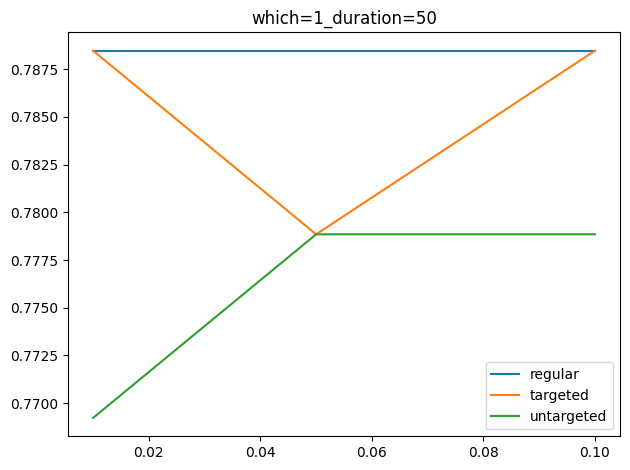

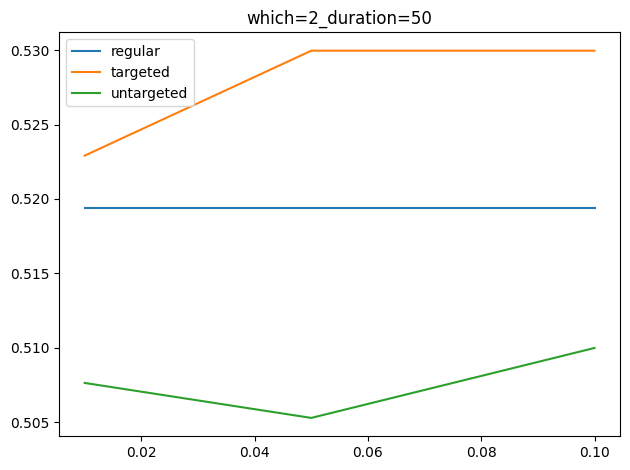

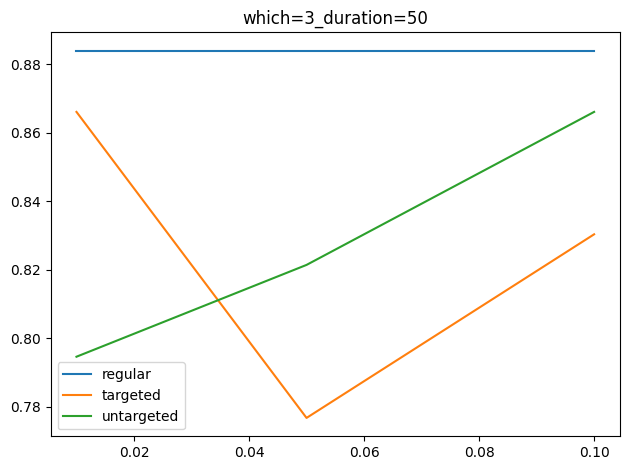

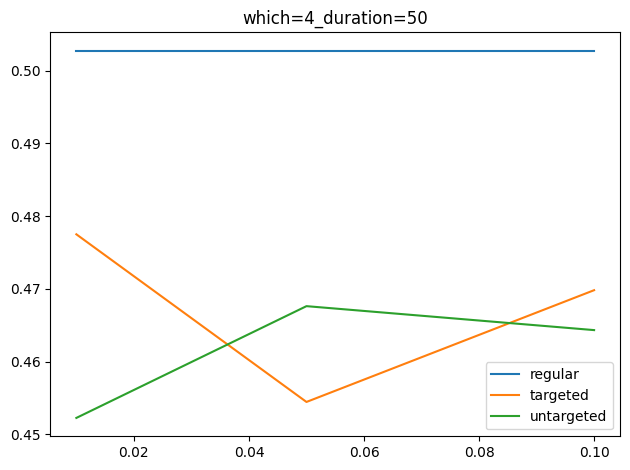

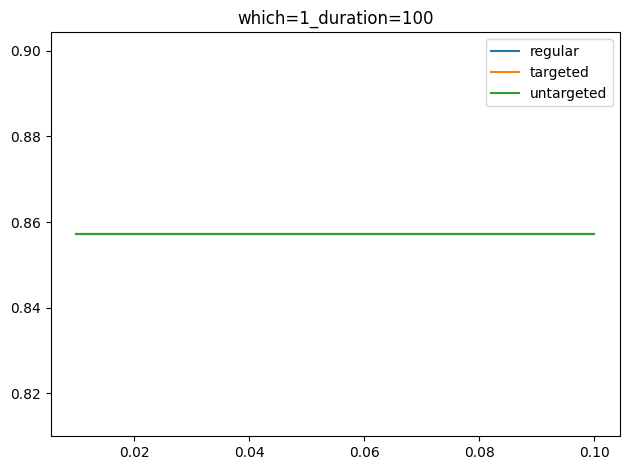

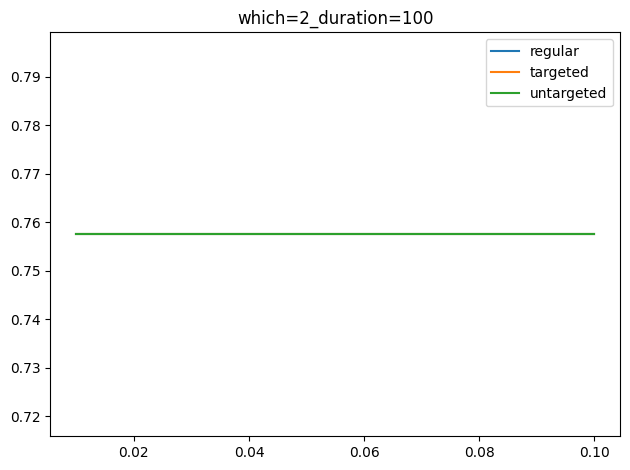

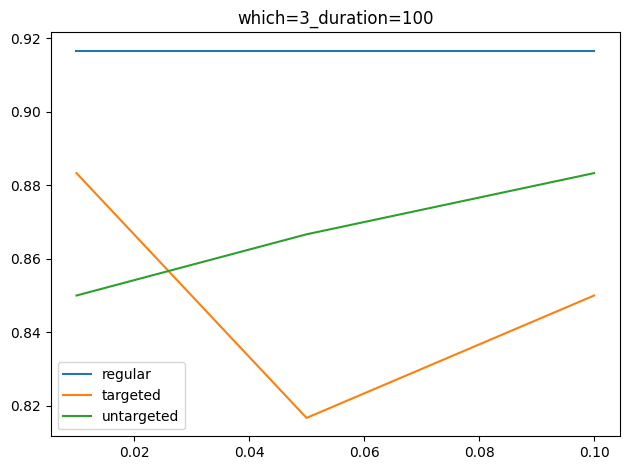

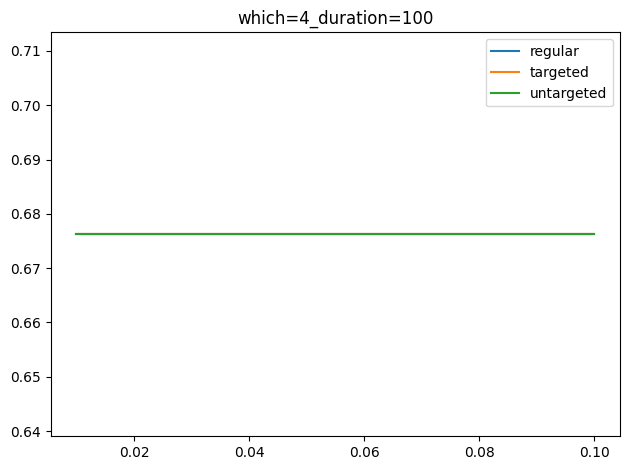

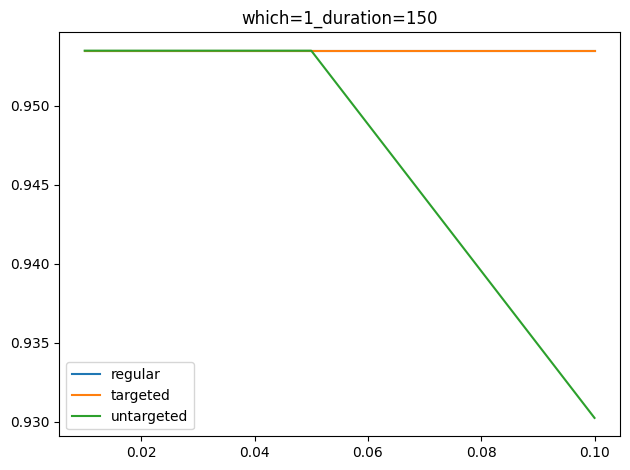

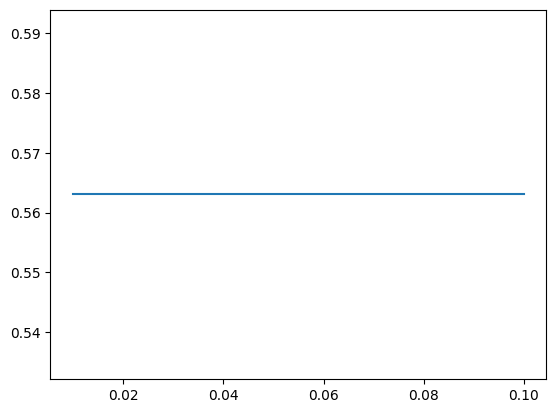

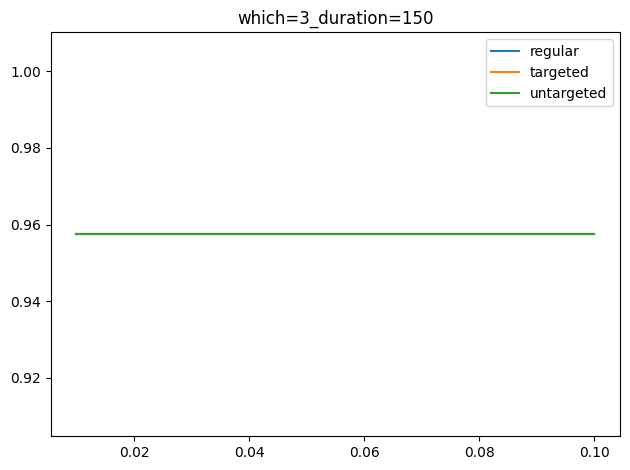

In [14]:
# For each model, plot the accuracy against perturbation size, both targeted and untargeted
cwd = Path().cwd()
model = 'max'
for experiment in model_params.keys():
    try:
        # get accuracy and adv accuracy
        dir = cwd / experiment
        if model == 'max':
            model_name = max([str(i) for i in dir.iterdir()])
        dir = dir / model_name
        print(dir)
        with open(str(dir / 'stats.json')) as f:
            stats = json.load(f)
        acc = stats['acc']
        attack_dir = dir / 'attacks'
        adv_accs = {'targeted': [], 'untargeted': []}
        for attack in attack_dir.iterdir():
            with open(str(attack / 'adv_stats.json')) as f:
                adv_stats = json.load(f)
            adv_acc = adv_stats['acc']
            size = float(str(attack).split('=')[-1])
            print(size)
            if 'untargeted' in str(attack):
                adv_accs['untargeted'].append(adv_acc)
            else:
                adv_accs['targeted'].append(adv_acc)
        
        # make the plot
        fig, ax = plt.subplots(1, 1)
        ax.plot(perturbation_sizes, [acc] * len(perturbation_sizes), label='regular')
        ax.plot(perturbation_sizes, adv_accs['targeted'], label='targeted')
        ax.plot(perturbation_sizes, adv_accs['untargeted'], label='untargeted')
        ax.legend()
        title = experiment.replace(prefix, '')
        ax.set_title(title)
        fig.tight_layout()
        fig.savefig(str(dir / 'accuracies.png'))
        fig.savefig(f'plots/{title}')
    except: 
        pass 